## piloting the in silico KO visualization

- Last updated: 08/30/2024
- Yang-Joon Kim


- We have computed cell-cell trans.probs for WT and all in silico KO cases (roughly 240 genes/TFs).
- We will use the Metacells computed separately, to (1) average the 2D transition vectors (single-cell level) across metacells, and (2) compute the metacell-metacell trans.probs, for "distance"/perturbation score computation.

In [1]:
### We will use TDR126 as an example

In [189]:
# Import public libraries
import copy
import glob
import importlib
import time
import os
import shutil
import sys
from importlib import reload

from scipy.stats import binned_statistic_2d
from scipy.sparse import csr_matrix
import scipy.sparse as sp
from scipy.spatial.distance import cosine

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from tqdm.notebook import tqdm

#import time

In [3]:
# Import CellOracle library
import celloracle as co
# from celloracle.applications import Oracle_development_module, Oracle_systematic_analysis_helper
co.__version__

/home/yang-joon.kim/.local/lib/python3.8/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/yang-joon.kim/.local/lib/python3.8/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
/home/yang-joon.kim/.local/lib

'0.18.0'

In [5]:
# import CellRank modules
import cellrank as cr
import scvelo as scv

### Plotting parameter setting

In [6]:
#plt.rcParams["font.family"] = "arial"
plt.rcParams["figure.figsize"] = [5,5]
%config InlineBackend.figure_format = 'retina'
plt.rcParams["savefig.dpi"] = 300
plt.rcParams['pdf.fonttype']=42

%matplotlib inline

In [7]:
import logging

# Set the logging level to WARN, filtering out informational messages
logging.getLogger().setLevel(logging.WARNING)

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default

# Set the default font to Arial
mpl.rcParams['font.family'] = 'Arial'

# If Arial is not available on your system, you might need to specify an alternative or ensure Arial is installed.
# On some systems, you might need to use 'font.sans-serif' as a fallback option:
# mpl.rcParams['font.sans-serif'] = 'Arial'

# Editable text and proper LaTeX fonts in illustrator
# matplotlib.rcParams['ps.useafm'] = True
# Editable fonts. 42 is the magic number for editable text in PDFs
mpl.rcParams['pdf.fonttype'] = 42
sns.set(style='whitegrid', context='paper')

# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none')

    # Override any previously set font settings to ensure Arial is used
    plt.rc('font', family='Arial')

In [196]:
data_id = "TDR126"
figpath = f"/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/figures/in_silico_KO_NMPs_subsets_metacells/{data_id}/"

# create the directory if not present already
os.makedirs(figpath, exist_ok=True)

### Step 1. Load the Oracle object with all cell-cell trans.probs

In [197]:
oracle = co.load_hdf5(f"/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/09_NMPs_subsetted_v2/14_{data_id}_in_silico_KO_trans_probs_added.celloracle.oracle")
oracle

Oracle object

Meta data
    celloracle version used for instantiation: 0.18.0
    n_cells: 4602
    n_genes: 3000
    cluster_name: manual_annotation
    dimensional_reduction_name: X_umap_aligned
    n_target_genes_in_TFdict: 13625 genes
    n_regulatory_in_TFdict: 872 genes
    n_regulatory_in_both_TFdict_and_scRNA-seq: 242 genes
    n_target_genes_both_TFdict_and_scRNA-seq: 1735 genes
    k_for_knn_imputation: 115
Status
    Gene expression matrix: Ready
    BaseGRN: Ready
    PCA calculation: Done
    Knn imputation: Done
    GRN calculation for simulation: Done

### Step 2. load the metacell information

- NOTE that the Metacell computing parameters should be consistent across timepoints
- We use "SEACells" method with 30cells/metacell.



In [227]:
metacell = pd.read_csv(f"/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/09_NMPs_subsetted_v2/metacells/{data_id}_seacells_obs_manual_annotation_30cells.csv", index_col=0)
metacell.head()

# make a dict - keys=cell_id : values=SEACEll
metacell_dict = metacell.SEACell.to_dict()

In [228]:
# add the metacell information to the oracle.adata
metacell_dict = metacell.SEACell.to_dict()
oracle.adata.obs["SEACell"] = oracle.adata.obs_names.map(metacell_dict)
oracle.adata.obs.head()

orig_ident  nCount_RNA  nFeature_RNA  nCount_ATAC  \
AAACAGCCAACACTTG-1_5  SeuratProject      3834.0          1637      36594.0   
AAACAGCCACAATGCC-1_5  SeuratProject      2593.0          1296      29241.0   
AAACAGCCACCTGGTG-1_5  SeuratProject      2632.0          1152      30638.0   
AAACAGCCAGTTATCG-1_5  SeuratProject      2578.0          1198      10486.0   
AAACATGCAAACTGCC-1_5  SeuratProject      2112.0           876       3866.0   

                      nFeature_ATAC  nucleosome_signal  nucleosome_percentile  \
AAACAGCCAACACTTG-1_5          16160           0.853561                   0.63   
AAACAGCCACAATGCC-1_5          12654           0.816789                   0.48   
AAACAGCCACCTGGTG-1_5          13500           0.853846                   0.63   
AAACAGCCAGTTATCG-1_5           5191           0.840000                   0.58   
AAACATGCAAACTGCC-1_5           1993           0.878613                   0.73   

                      TSS_enrichment  TSS_percentile  nCount_SCT  ...  \
AAACAGCCAACACTTG-1_5        4.182484            0.11      3246.0  ...   
AAACAGCCACAATGCC-1_5        4.942979            0.82      2701.0  ...   
AAACAGCCACCTGGTG-1_5        4.093974            0.07      2736.0  ...   
AAACAGCCAGTTATCG-1_5        4.407357            0.29      2703.0  ...   
AAACATGCAAACTGCC-1_5        4.577241            0.47      2567.0  ...   

                         annotation_ML                scANVI_zscape  \
AAACAGCCAACACTTG-1_5       spinal_cord          pronephric podocyte   
AAACAGCCACAATGCC-1_5               PSM       slow-committed myocyte   
AAACAGCCACCTGGTG-1_5  neural_posterior          pronephric podocyte   
AAACAGCCAGTTATCG-1_5              NMPs  fin bud mesoderm (pectoral)   
AAACATGCAAACTGCC-1_5               PSM  fin bud mesoderm (pectoral)   

                      annotation_ML_coarse  dev_stage  timepoints  \
AAACAGCCAACACTTG-1_5           spinal_cord   0somites    0somites   
AAACAGCCACAATGCC-1_5                   PSM   0somites    0somites   
AAACAGCCACCTGGTG-1_5      neural_posterior   0somites    0somites   
AAACAGCCAGTTATCG-1_5                  NMPs   0somites    0somites   
AAACATGCAAACTGCC-1_5                   PSM   0somites    0somites   

                      manual_annotation  Pseudotime  Pseudotime_Lineage_Meso  \
AAACAGCCAACACTTG-1_5        spinal_cord    5.524281                      NaN   
AAACAGCCACAATGCC-1_5                PSM   16.707586                16.707586   
AAACAGCCACCTGGTG-1_5   neural_posterior   15.859267                      NaN   
AAACAGCCAGTTATCG-1_5               NMPs    0.581532                 0.581532   
AAACATGCAAACTGCC-1_5                PSM    8.785265                 8.785265   

                      Pseudotime_Lineage_NeuroEcto      SEACell  
AAACAGCCAACACTTG-1_5                      5.524281   SEACell-35  
AAACAGCCACAATGCC-1_5                           NaN   SEACell-93  
AAACAGCCACCTGGTG-1_5                     15.859267  SEACell-151  
AAACAGCCAGTTATCG-1_5                      0.581532   SEACell-13  
AAACATGCAAACTGCC-1_5                           NaN  SEACell-130  

[5 rows x 40 columns]

In [224]:
# sc.pl.embedding(oracle.adata, basis="X_umap_aligned", color="SEACell")

In [284]:
# Color palette for cell types
cell_type_color_dict = {
    'NMPs': '#8dd3c7',
    'PSM': '#008080',
    'fast_muscle': '#df4b9b',
    'neural_posterior': '#393b7f',
    'somites': '#1b9e77',
    'spinal_cord': '#d95f02',
    'tail_bud': '#7570b3'
}

# computing the average of 2D transition vectors @Metacell level
def average_2D_trans_vecs_metacells(adata, metacell_col="SEACell", 
                                    basis='umap_aligned',key_added='WT'):
    X_umap = adata.obsm[f'X_{basis}']
    # Your cell-level 2D transition vectors
    # V_cell = adata.obsm[f'{key_added}_{basis}'] 
    V_cell = adata.obsm[f"{key_added}"]

    # metacells = adata.obs[metacell_col].cat.codes
    
    # Convert metacell column to categorical if it's not already
    if not pd.api.types.is_categorical_dtype(adata.obs[metacell_col]):
        metacells = pd.Categorical(adata.obs[metacell_col])
    else:
        metacells = adata.obs[metacell_col]
    # number of metacells    
    n_metacells = len(metacells.categories)
    
    # X_metacell is the average UMAP position of the metacells
    # V_metacell is the average transition vector of the metacells
    X_metacell = np.zeros((n_metacells, 2))
    V_metacell = np.zeros((n_metacells, 2))
    
    for i, category in enumerate(metacells.categories):
        mask = metacells == category
        X_metacell[i] = X_umap[mask].mean(axis=0)
        V_metacell[i] = V_cell[mask].mean(axis=0)
    
    return X_metacell, V_metacell

# plotting function for the averaged trans_vectors
# metacell_col = 'SEACell'  # Replace with your metacell column name
# basis="umap_aligned"
def plot_metacell_transitions(adata, X_metacell, V_metacell, data_id,
                                figpath=None,
                                metacell_col="SEACell", 
                                annotation_class="manual_annotation",
                                basis='umap_aligned', genotype="WT",
                                cell_type_color_dict = cell_type_color_dict,
                                cell_size=10, SEACell_size=20,
                                scale=1, arrow_scale=15, arrow_width=0.002, dpi=120):
    
    # create a figure object (matplotlib)
    fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

    # Prepare data for plotting
    umap_coords = pd.DataFrame(adata.obsm[f'X_{basis}'], columns=[0, 1], index=adata.obs_names)
    umap_data = umap_coords.join(adata.obs[[metacell_col, annotation_class]])
    umap_data = umap_data.rename(columns={annotation_class: 'celltype'})

    # Plot single cells
    sns.scatterplot(
        x=0, y=1, hue='celltype', data=umap_data, s=cell_size, 
        palette=cell_type_color_dict, legend=None, ax=ax, alpha=0.7
    )

    # Calculate most prevalent cell type for each metacell
    most_prevalent = adata.obs.groupby(metacell_col)[annotation_class].agg(lambda x: x.value_counts().idxmax())

    # Prepare metacell data
    mcs = umap_data.groupby(metacell_col).mean().reset_index()
    mcs['celltype'] = most_prevalent.values

    # Plot metacells
    sns.scatterplot(
        x=0, y=1, s=SEACell_size, hue='celltype', data=mcs,
        palette=cell_type_color_dict, edgecolor='black', linewidth=1.25,
        legend=None, ax=ax
    )

    # Plot transition vectors
    Q = ax.quiver(X_metacell[:, 0], X_metacell[:, 1], V_metacell[:, 0], V_metacell[:, 1],
                angles='xy', scale_units='xy', scale=1/arrow_scale, width=arrow_width,
                color='black', alpha=0.8)

    # Customize the plot
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    # Remove x and y ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)

    # # Create custom legend
    # handles = [mpatches.Patch(color=color, label=label) 
    #         for label, color in cell_type_color_dict.items() 
    #         if label in umap_data['celltype'].unique()]
    # ax.legend(handles=handles, title='Cell Types', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.title(f'Metacell Transitions on {basis.upper()}')
    plt.tight_layout()
    plt.grid(False)
    if figpath:
        plt.savefig(figpath + f"umap_{genotype}_metacell_aggre_trans_probs_{data_id}.png")
        plt.savefig(figpath + f"umap_{genotype}_metacell_aggre_trans_probs_{data_id}.pdf")
    # plt.show()
    # plt.show()
    return fig

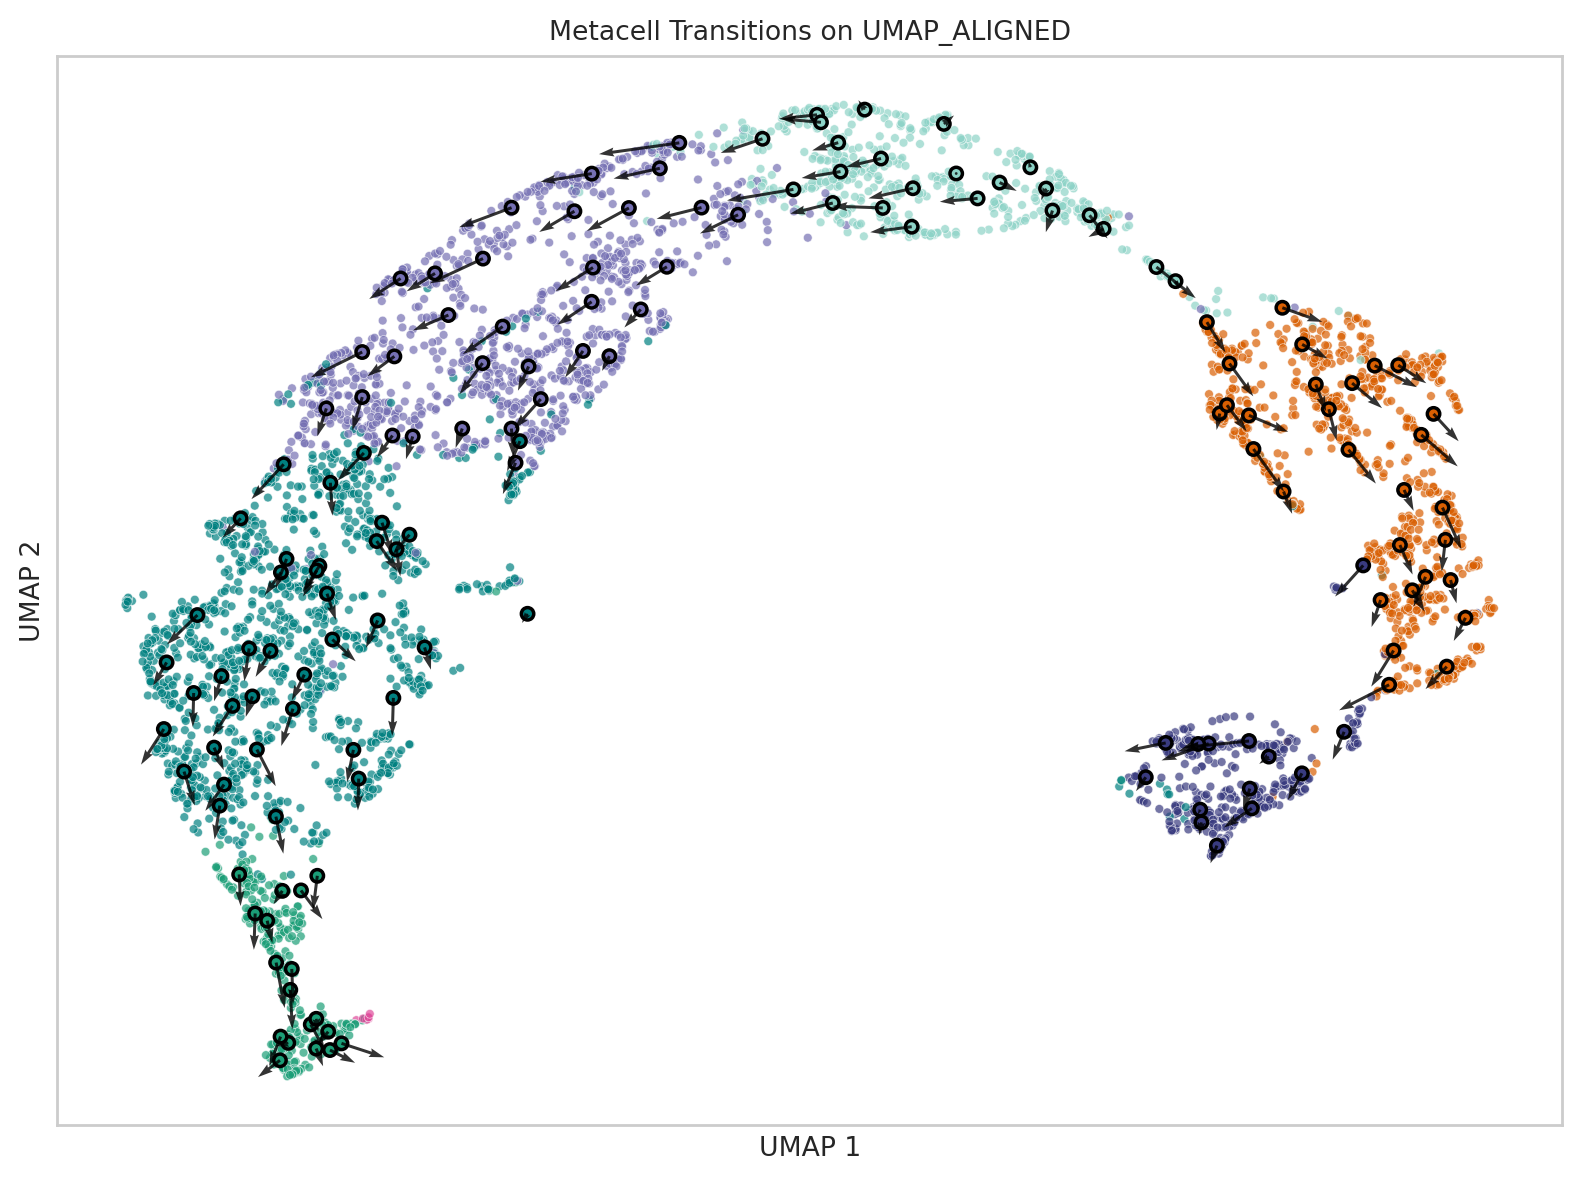

In [159]:
# WT ("local" pseudotime)
# average the 2D embedding and 2D transition vectors across "metacells"
X_metacell, V_metacell = average_2D_trans_vecs_metacells(oracle.adata, 
                                                         metacell_col="SEACell", 
                                                         basis='umap_aligned',
                                                         key_added='WT')

# generate the plot and save it in the folder
plot_metacell_transitions(oracle.adata, X_metacell, V_metacell,data_id="TDR126",
                            figpath=figpath,
                            metacell_col="SEACell", 
                            annotation_class="manual_annotation",
                            basis='umap_aligned', genotype="WT")

plt.savefig(figpath + "")

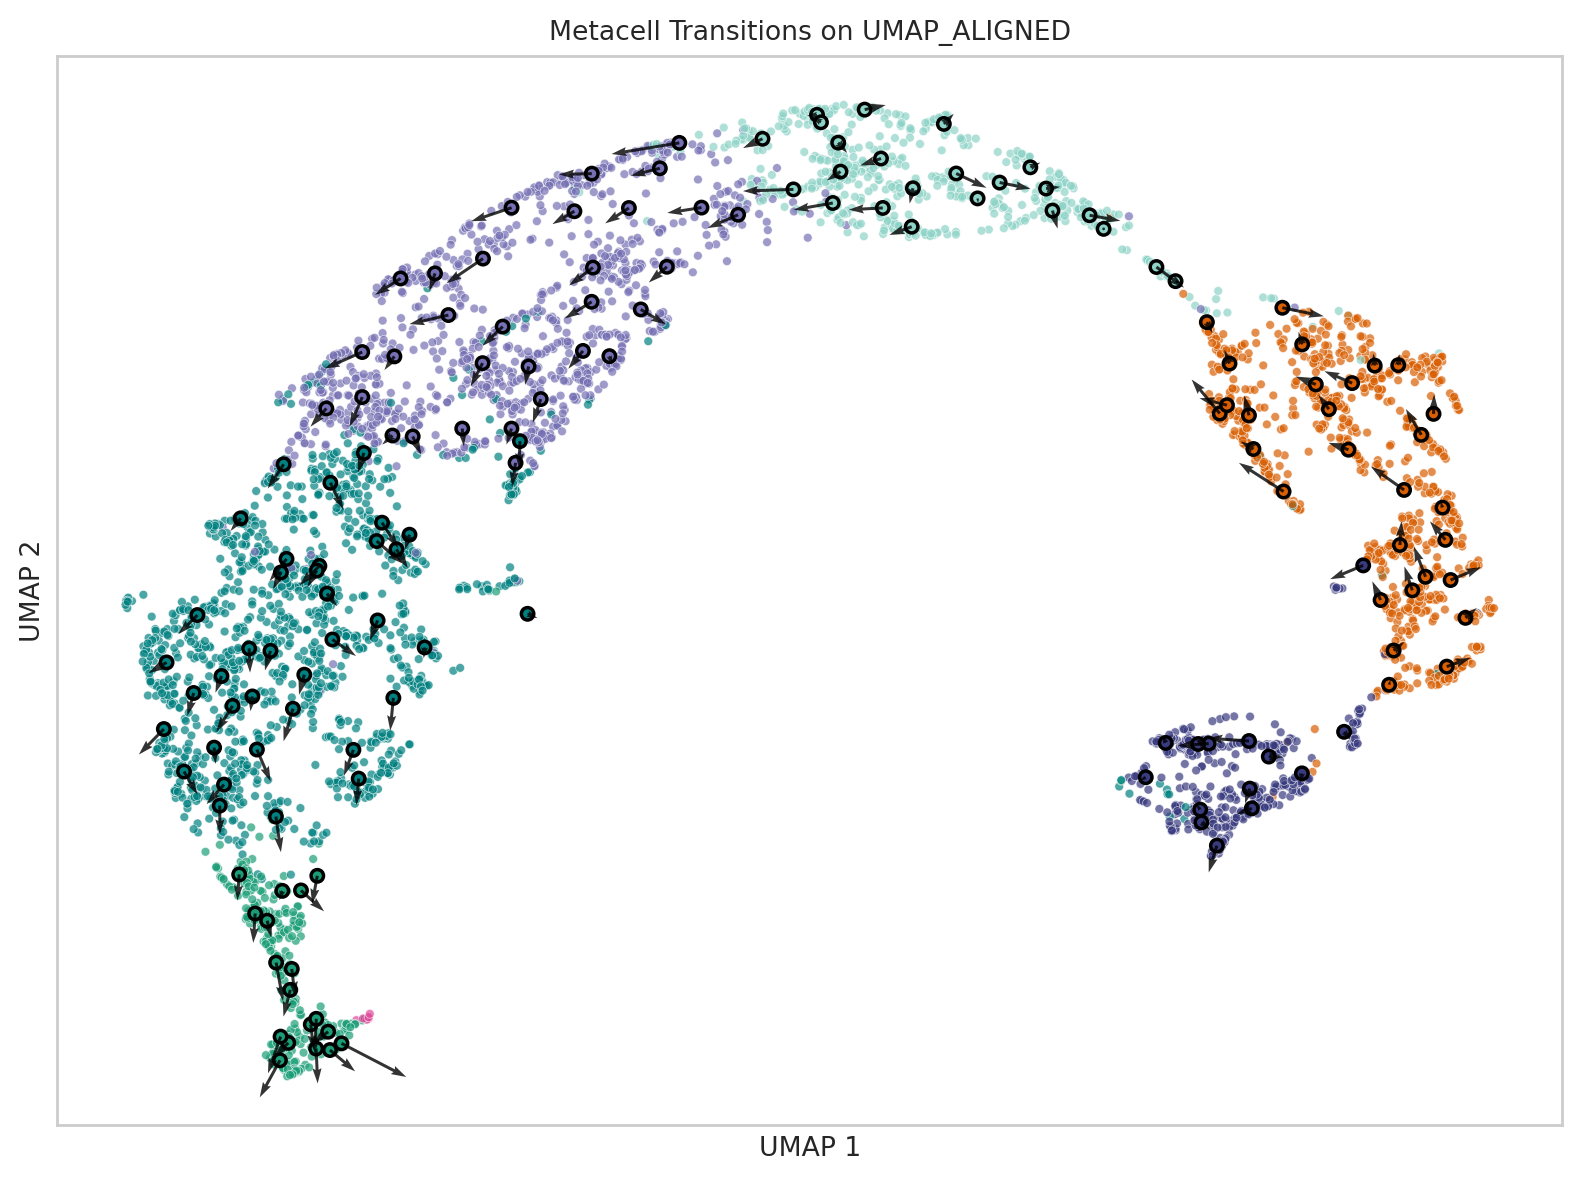

In [160]:
# WT ("global" pseudotime)
# average the 2D embedding and 2D transition vectors across "metacells"
X_metacell, V_metacell = average_2D_trans_vecs_metacells(oracle.adata, 
                                                         metacell_col="SEACell", 
                                                         basis='umap_aligned',
                                                         key_added='WT_global')

# generate the plot and save it in the folder
plot_metacell_transitions(oracle.adata, X_metacell, V_metacell,data_id="TDR126",
                            figpath=figpath,
                            metacell_col="SEACell", 
                            annotation_class="manual_annotation",
                            basis='umap_aligned', genotype="WT_global")

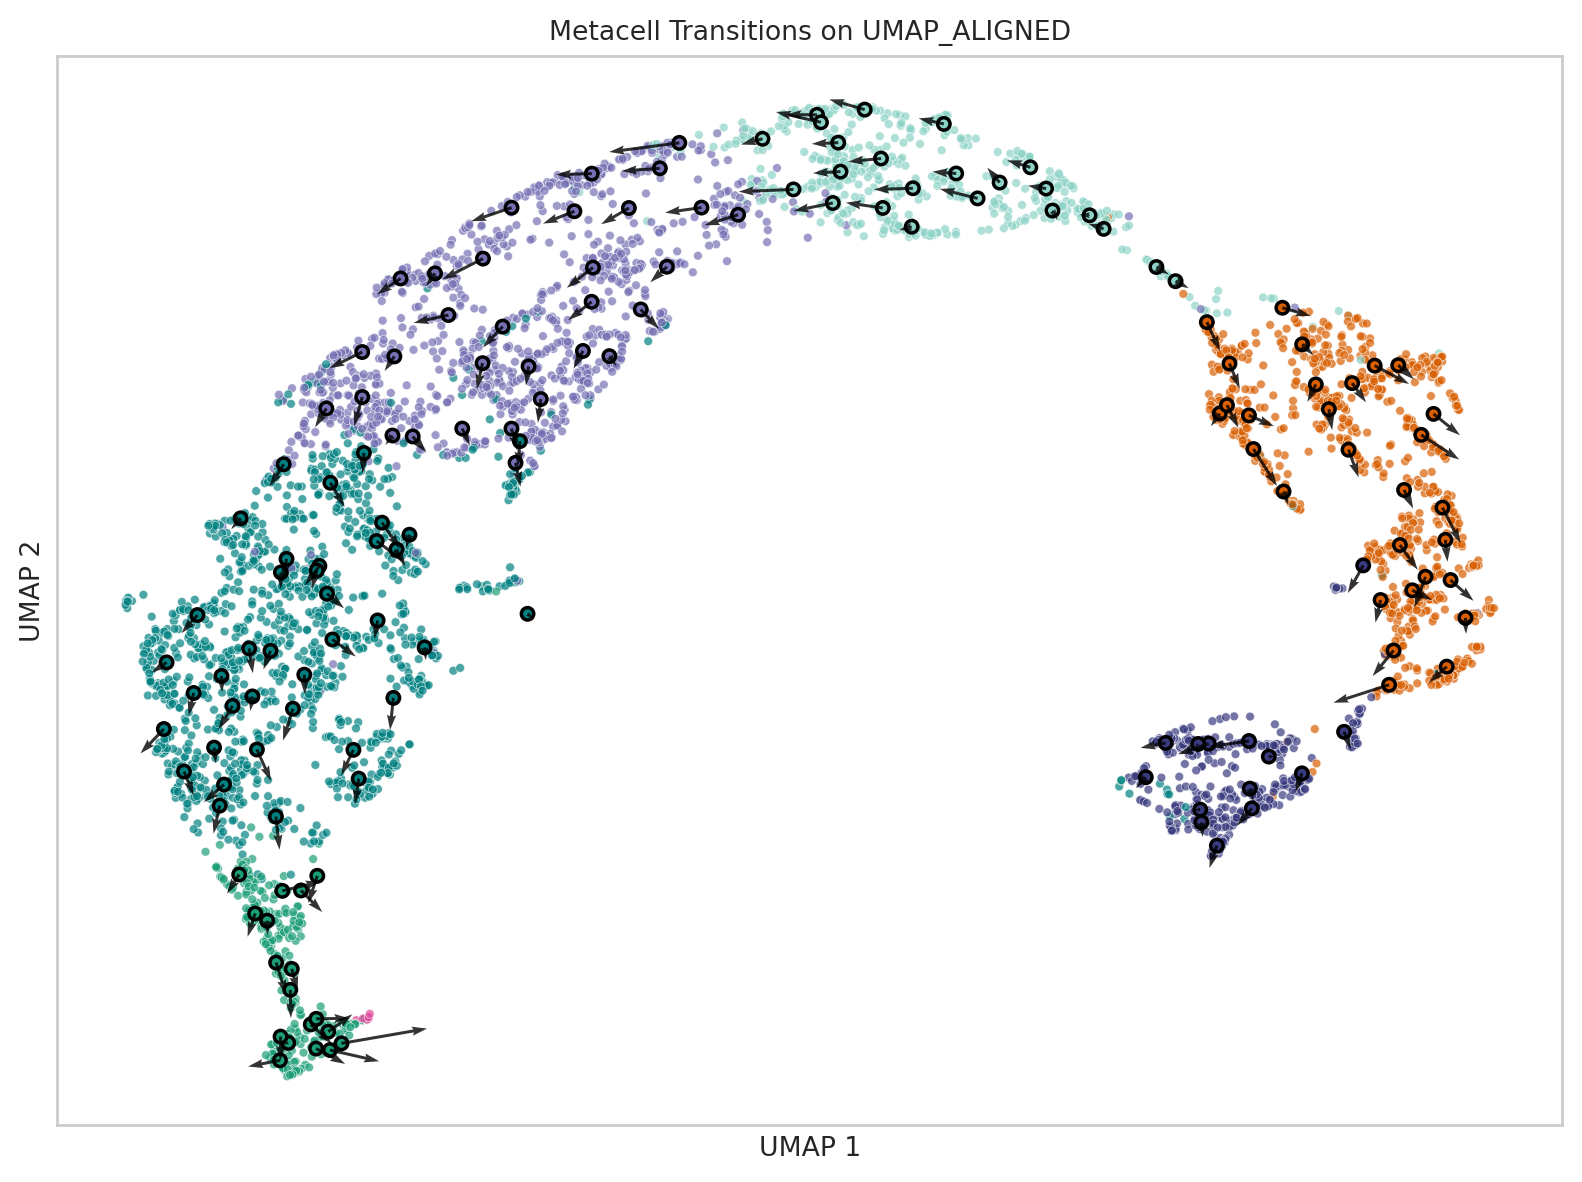

In [161]:
# WT ("global" pseudotime)
# average the 2D embedding and 2D transition vectors across "metacells"
X_metacell, V_metacell = average_2D_trans_vecs_metacells(oracle.adata, 
                                                         metacell_col="SEACell", 
                                                         basis='umap_aligned',
                                                         key_added='WT_global_nmps')

# generate the plot and save it in the folder
plot_metacell_transitions(oracle.adata, X_metacell, V_metacell,data_id="TDR126",
                            figpath=figpath,
                            metacell_col="SEACell", 
                            annotation_class="manual_annotation",
                            basis='umap_aligned', genotype="WT_global_nmps")

## [08/28/2024] debugging the cell-cell transition probabilities and their 2D projections for in silico KOs.

- the issue that we've seen is that the 2D projected vectors (averaged over Metacells) were more or less the same for any KO genes.

- 1) check if the cell-cell trans.probs look different for a couple of marker genes
    - YES. cell-cell trans.probs from CellOracle is fine. (also by plotting using the CellOracle viz)

- 2) check if the metacell-metacell trans.probs look different for a couple of marker genes
    - YES. 

- 3) check if the 2D trans.vectors for each cell looks reasonable (for the same genes)
    - YES. This one looks reasonable when plotted with CellRank, as well as CellOracle.

- 4) check if the metacell level averaging/smoothing makes sense.
    - This one is unclear...

In [254]:
# oracle_test = co.load_hdf5("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/")

In [251]:
oracle

Oracle object

Meta data
    celloracle version used for instantiation: 0.18.0
    n_cells: 4602
    n_genes: 3000
    cluster_name: manual_annotation
    dimensional_reduction_name: X_umap_aligned
    n_target_genes_in_TFdict: 13625 genes
    n_regulatory_in_TFdict: 872 genes
    n_regulatory_in_both_TFdict_and_scRNA-seq: 242 genes
    n_target_genes_both_TFdict_and_scRNA-seq: 1735 genes
    k_for_knn_imputation: 115
Status
    Gene expression matrix: Ready
    BaseGRN: Ready
    PCA calculation: Done
    Knn imputation: Done
    GRN calculation for simulation: Done

In [253]:
from scipy import sparse

KO_gene = "meox1"

# Enter perturbation conditions to simulate signal propagation after the perturbation.
oracle.simulate_shift(perturb_condition={KO_gene: 0.0},
                    n_propagation=3)
# Compute the cell-cell transition probabilities for each KO gene
# Get transition probability
oracle.estimate_transition_prob(n_neighbors=200,
                                knn_random=True,
                                sampled_fraction=1)

# Calculate embedding
oracle.calculate_embedding_shift(sigma_corr=0.05)

# extract the cell-cell trans.probs
trans_prob_KO = oracle.transition_prob
# convert from dense to sparse matrix
trans_prob_KO = sparse.csr_matrix(trans_prob_KO)

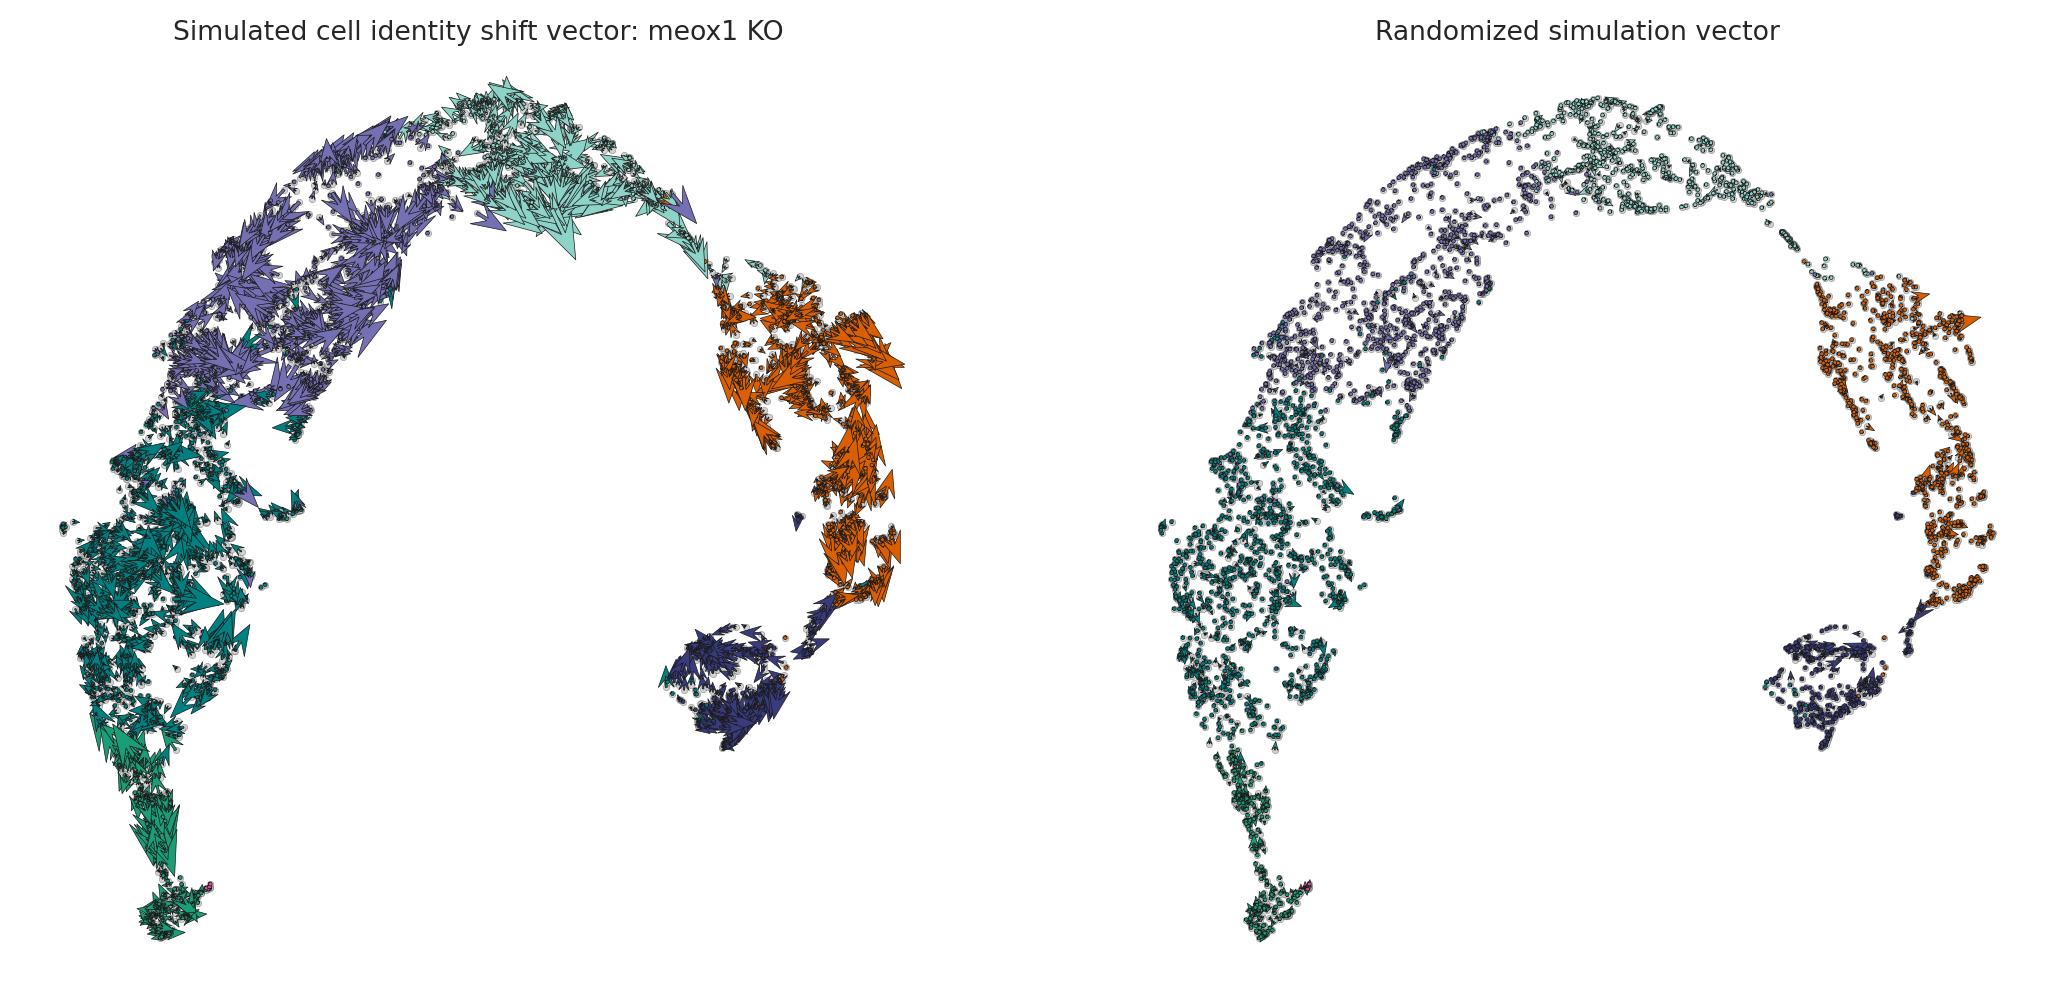

In [256]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale = 25
# Show quiver plot
oracle.plot_quiver(scale=scale, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {KO_gene} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_quiver_random(scale=scale, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

In [270]:
# n_grid = 40 is a good starting value.
n_grid = 40
oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)

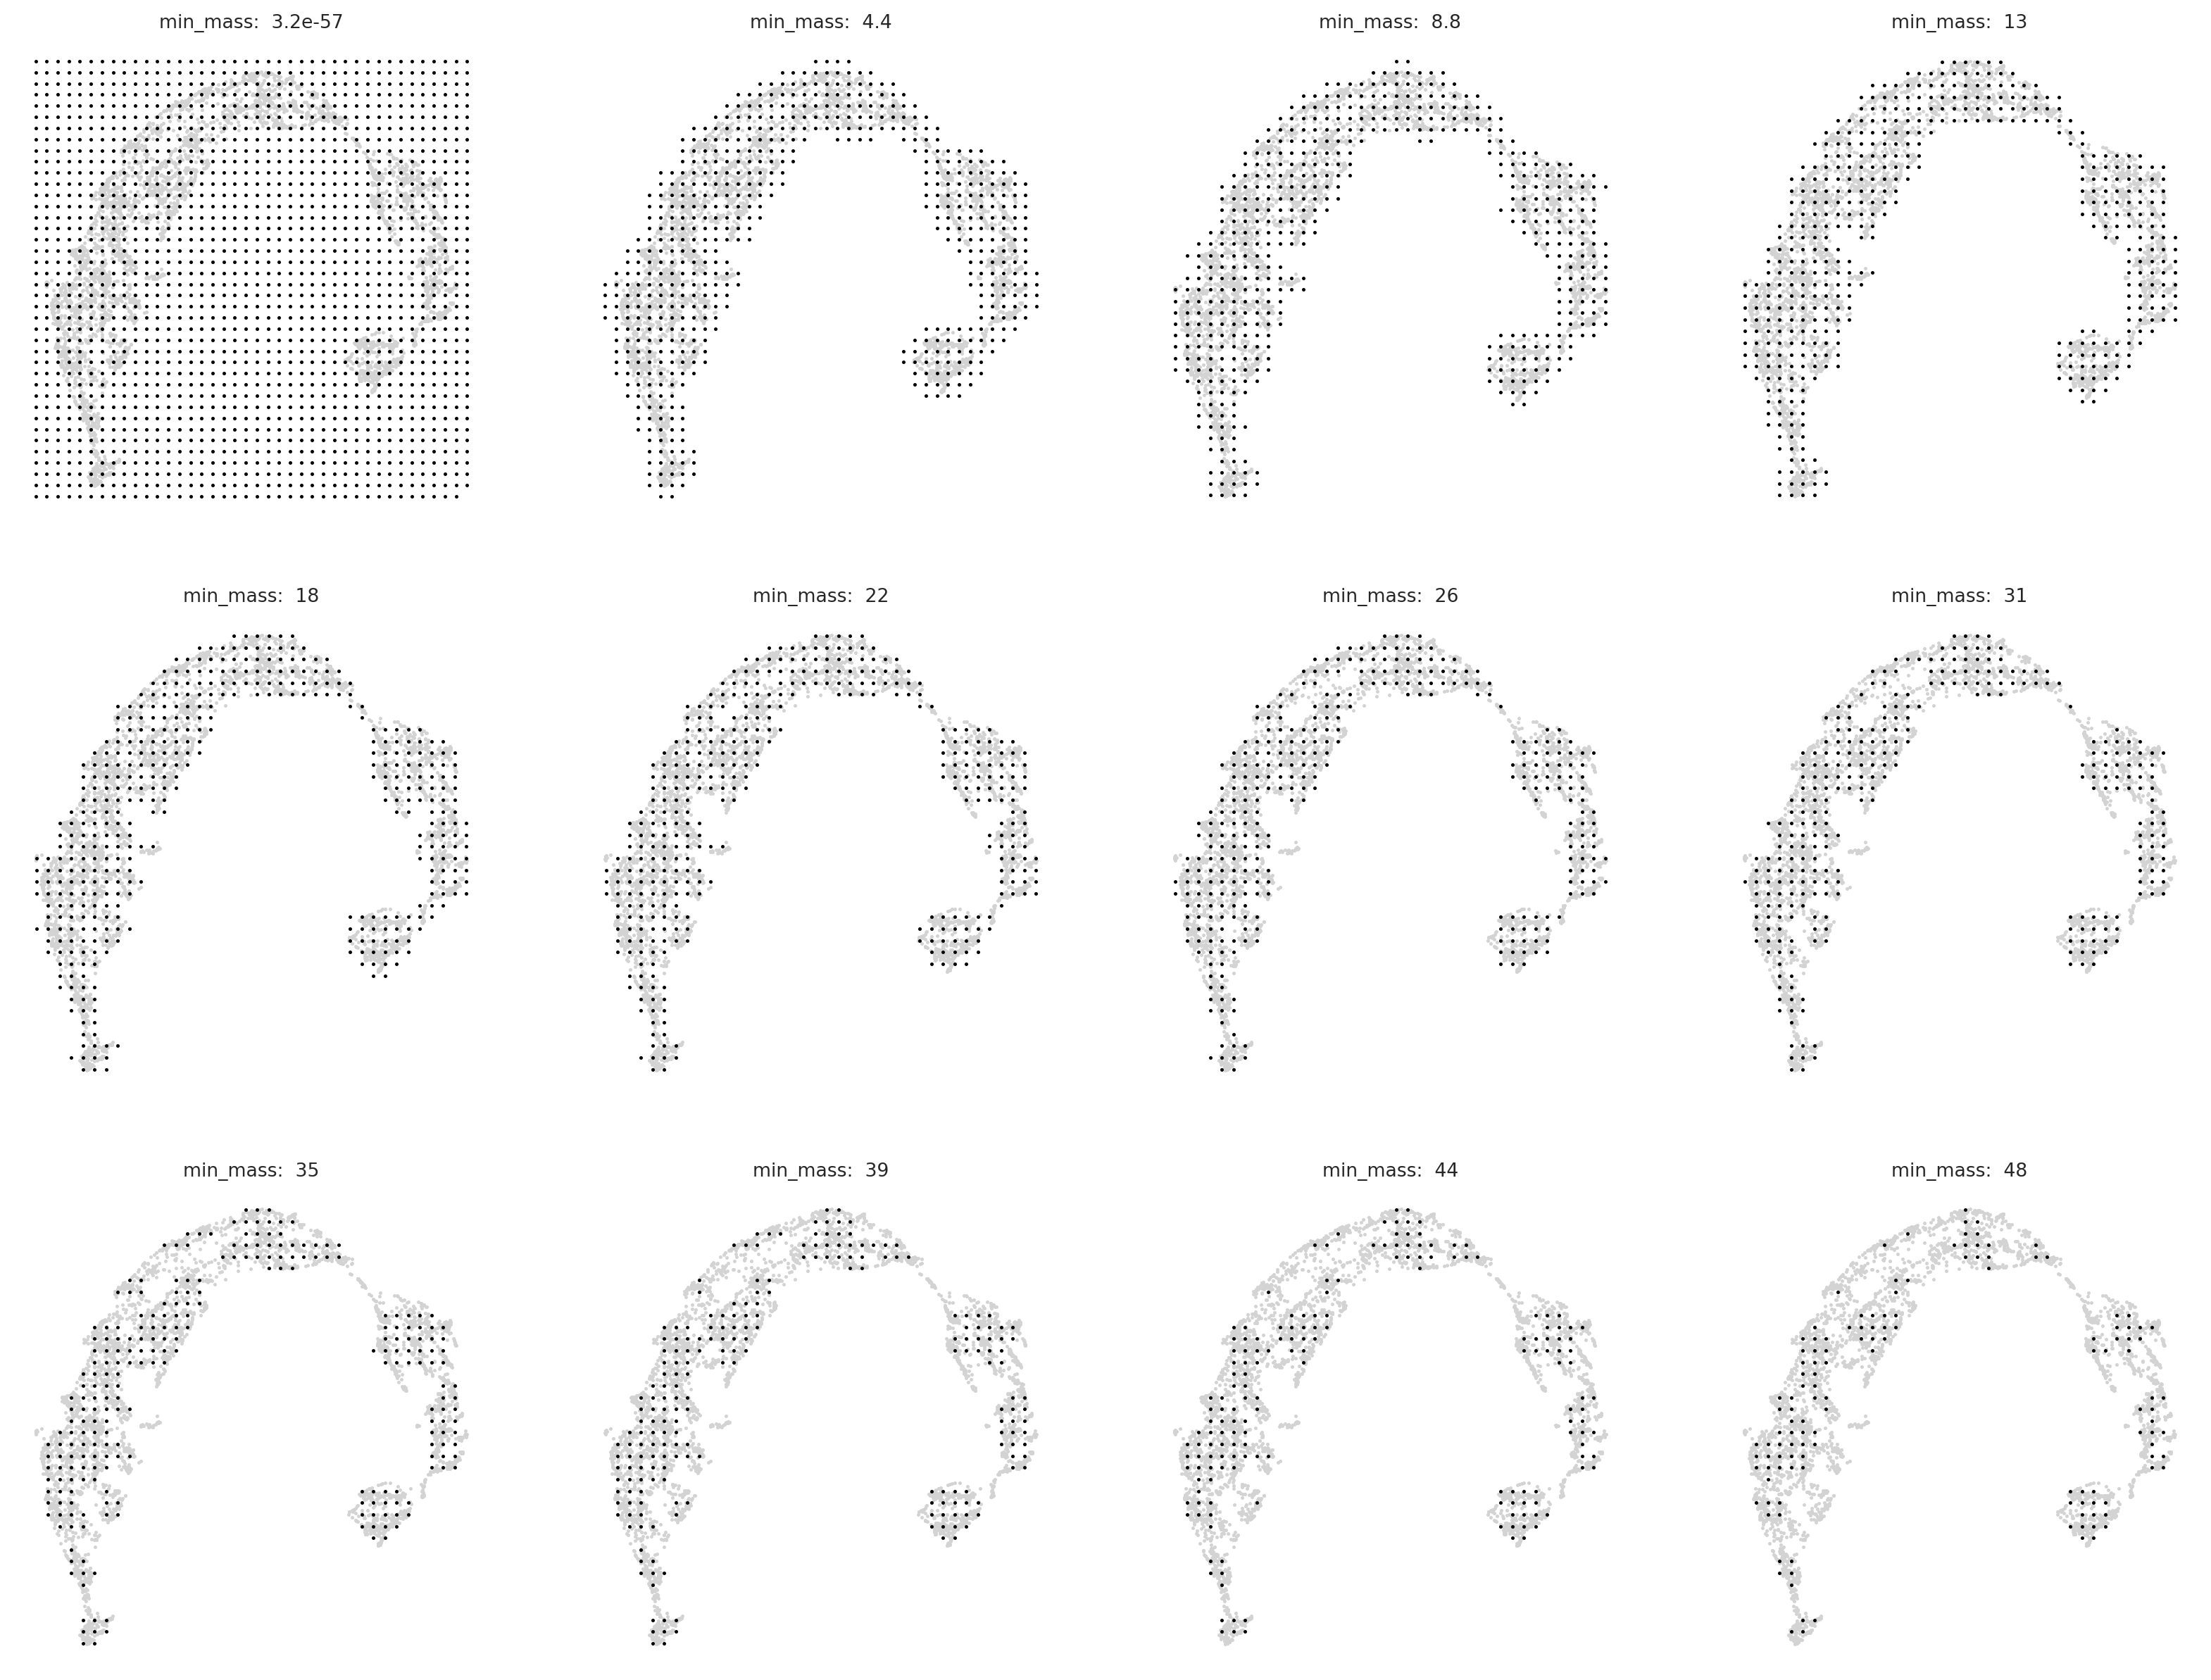

In [272]:
# Search for best min_mass.
oracle.suggest_mass_thresholds(n_suggestion=12)
plt.show()

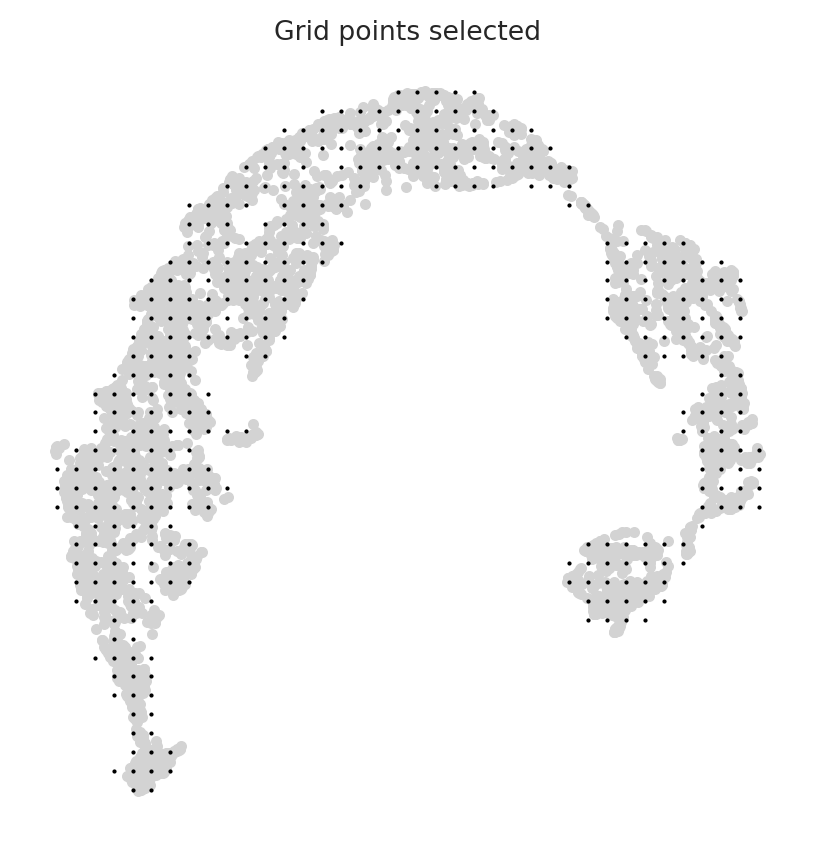

In [273]:
min_mass = 22
oracle.calculate_mass_filter(min_mass=min_mass, plot=True)
plt.show()

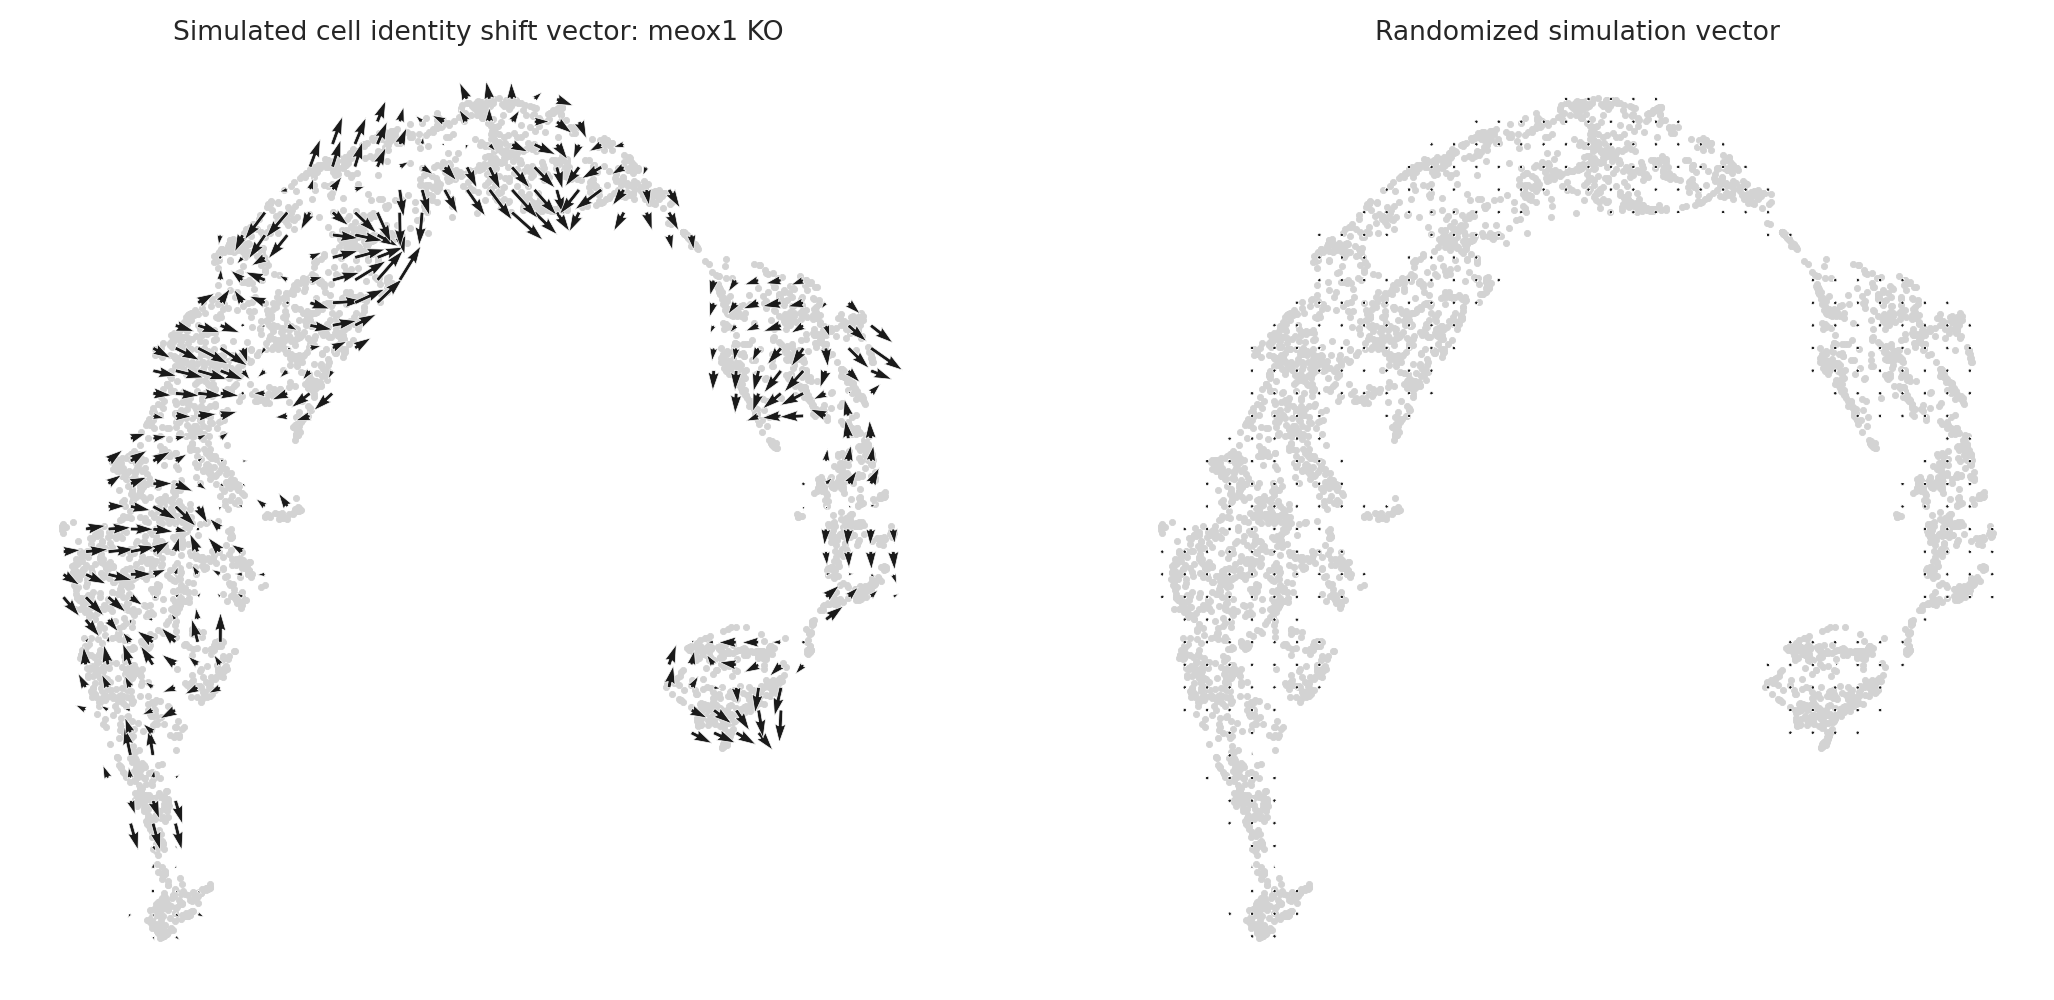

In [260]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale_simulation = 10
# Show quiver plot
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {KO_gene} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

In [ ]:
### check for other gene KOs

In [306]:
list_KO_genes = ["meox1","msgn1","cdx4","tbx16","myod1","myf5","myog",
                "pax6a","pax6b","sox3","sox19","meis1a","meis1b",
                "hoxc3a","hoxc3b","meis2a","meis3","nr2f5","pax3b","rxraa"]

list_KO_genes_filtered = [gene for gene in list_KO_genes if gene in oracle.active_regulatory_genes]
list_KO_genes_filtered

['meox1',
 'cdx4',
 'tbx16',
 'myod1',
 'myf5',
 'pax6a',
 'pax6b',
 'sox3',
 'meis1a',
 'meis2a',
 'meis3',
 'nr2f5',
 'pax3b',
 'rxraa']

In [266]:
# from scipy import sparse

KO_gene = "pax6b"

# Enter perturbation conditions to simulate signal propagation after the perturbation.
oracle.simulate_shift(perturb_condition={KO_gene: 0.0},
                    n_propagation=3)
# Compute the cell-cell transition probabilities for each KO gene
# Get transition probability
oracle.estimate_transition_prob(n_neighbors=200,
                                knn_random=True,
                                sampled_fraction=1)

# Calculate embedding
oracle.calculate_embedding_shift(sigma_corr=0.05)

# extract the cell-cell trans.probs
trans_prob_KO = oracle.transition_prob
# convert from dense to sparse matrix
trans_prob_KO = sparse.csr_matrix(trans_prob_KO)

# re-compute the p_mass (minimum cell density per grid)
oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)
min_mass = 22
oracle.calculate_mass_filter(min_mass=min_mass, plot=True)

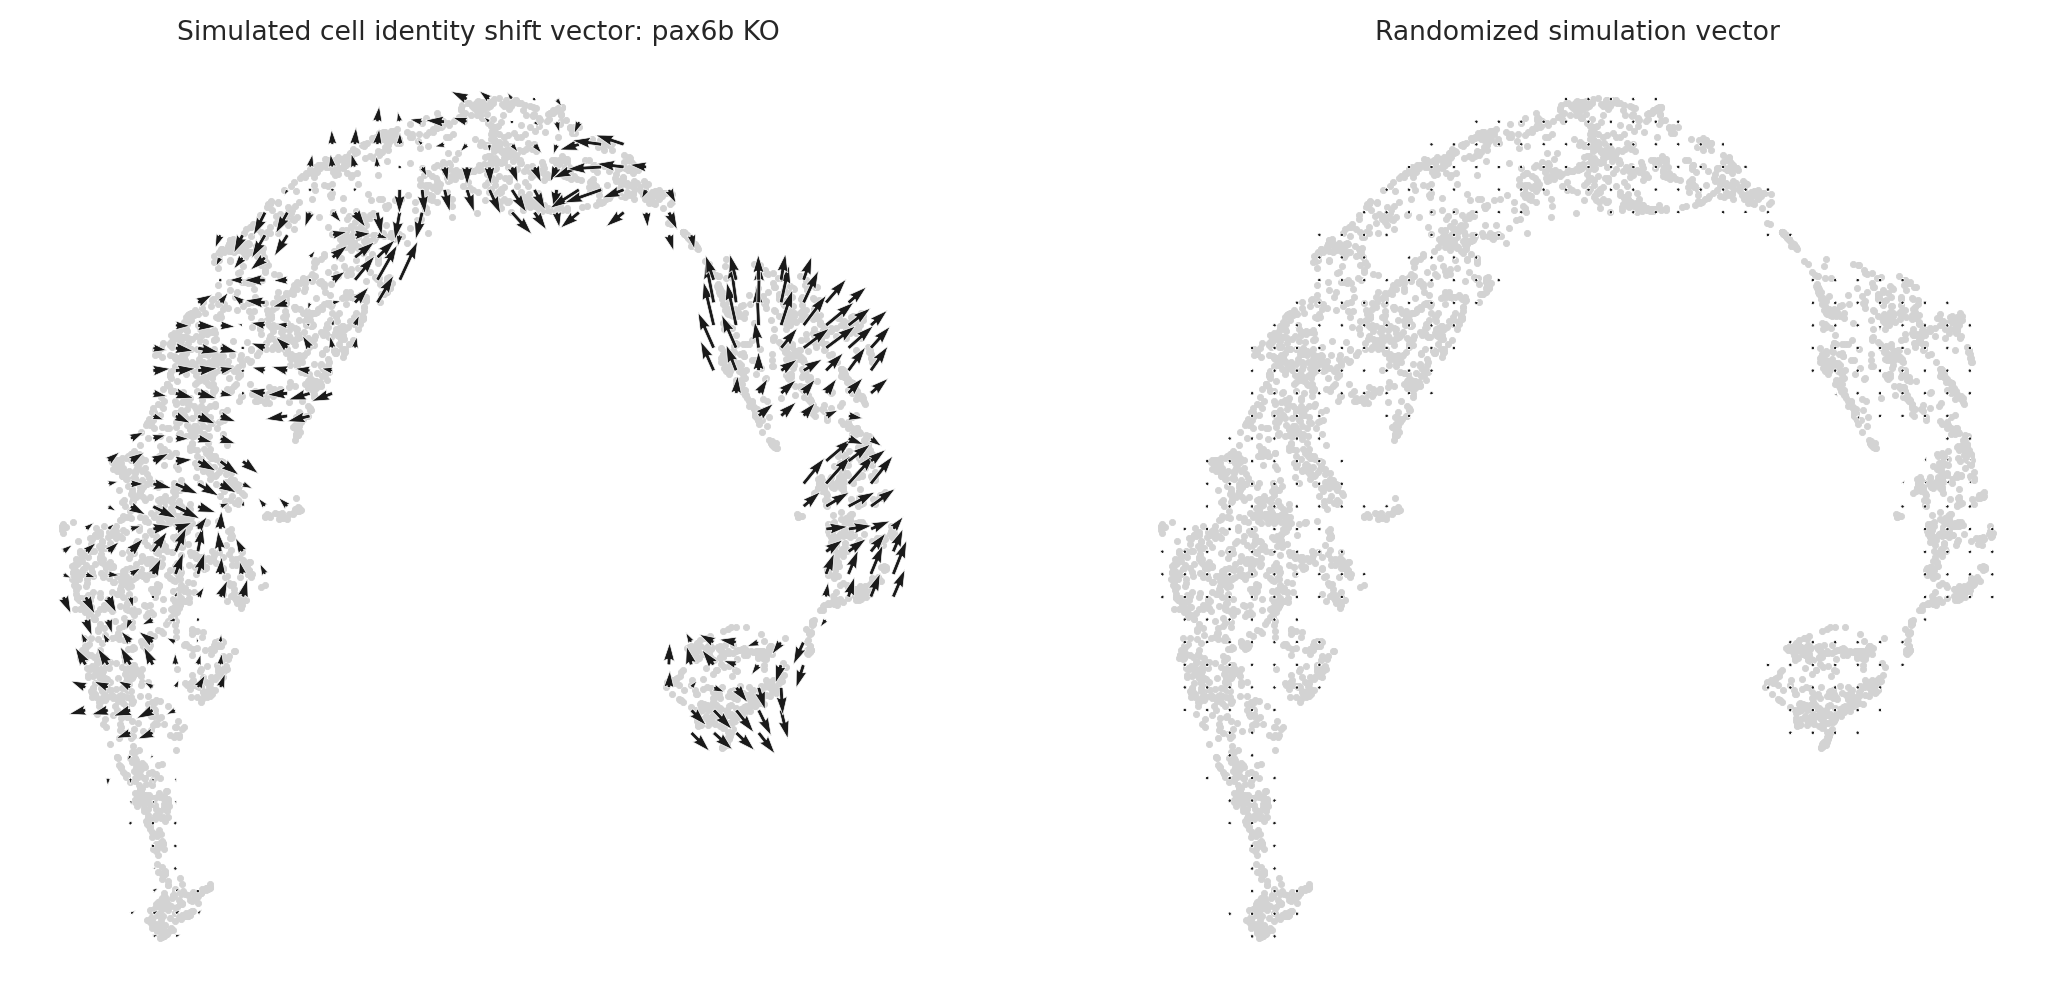

In [274]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale_simulation = 10
# Show quiver plot
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {KO_gene} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

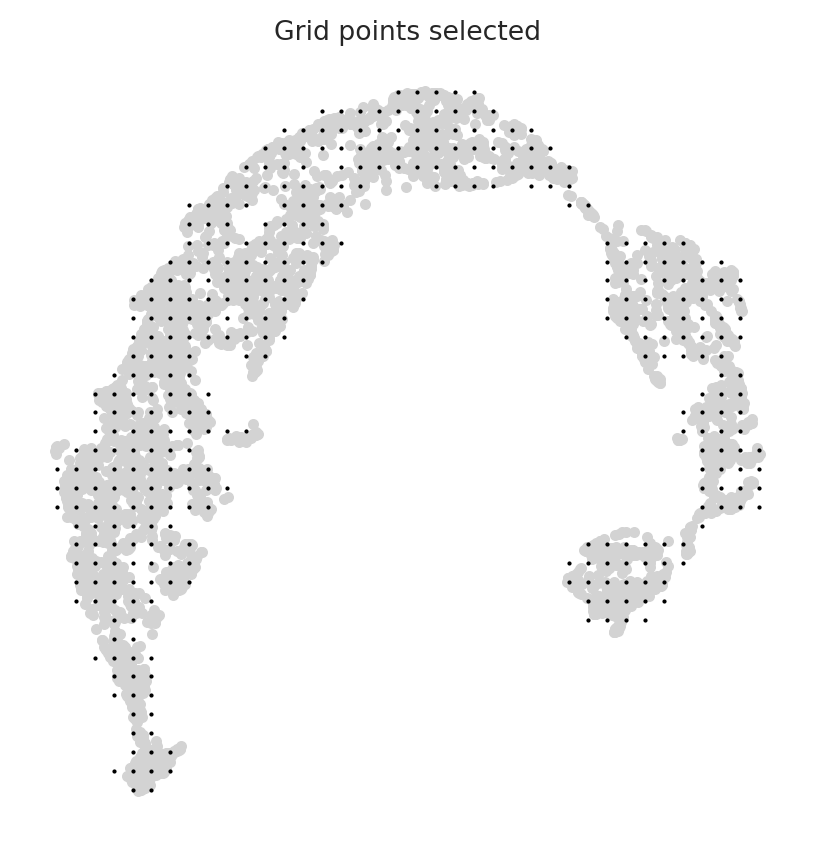

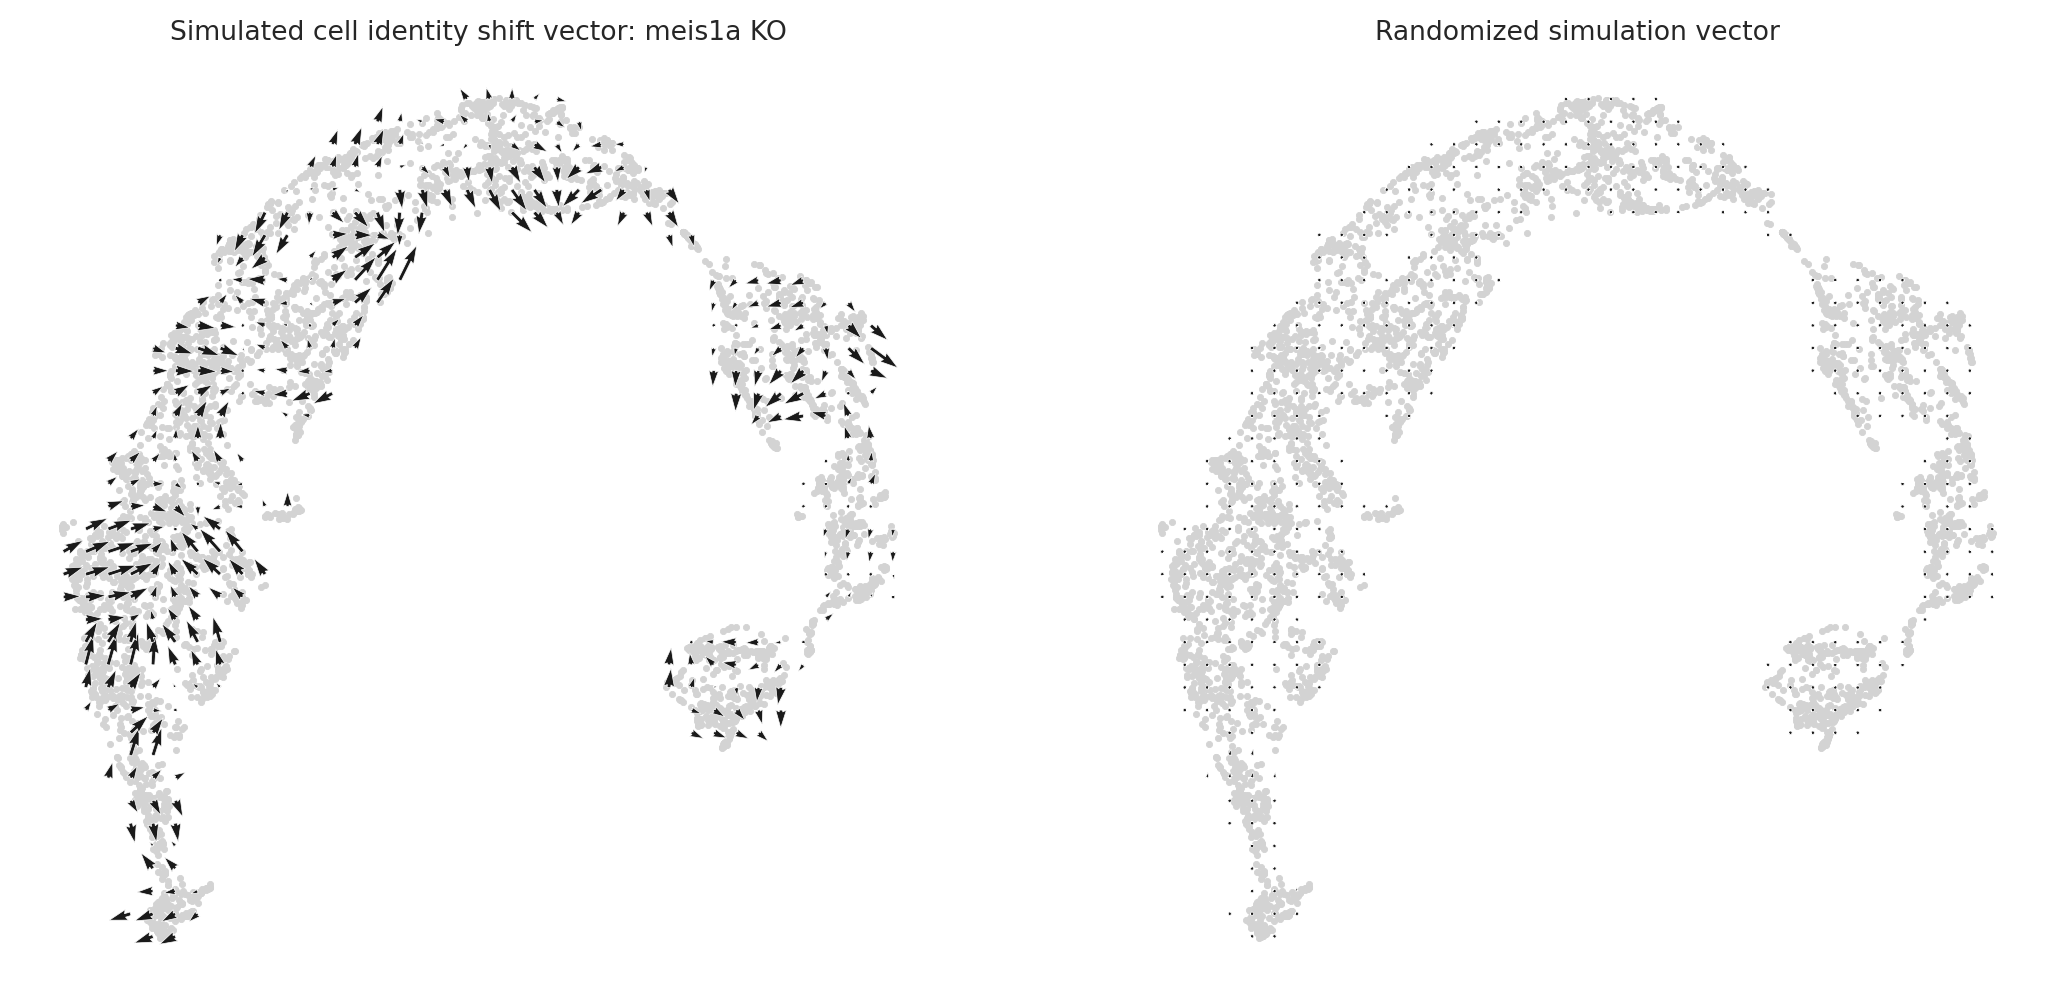

In [275]:
# from scipy import sparse
KO_gene = "meis1a"

# Enter perturbation conditions to simulate signal propagation after the perturbation.
oracle.simulate_shift(perturb_condition={KO_gene: 0.0},
                    n_propagation=3)
# Compute the cell-cell transition probabilities for each KO gene
# Get transition probability
oracle.estimate_transition_prob(n_neighbors=200,
                                knn_random=True,
                                sampled_fraction=1)

# Calculate embedding
oracle.calculate_embedding_shift(sigma_corr=0.05)

# extract the cell-cell trans.probs
trans_prob_KO = oracle.transition_prob
# convert from dense to sparse matrix
trans_prob_KO = sparse.csr_matrix(trans_prob_KO)

# re-compute the p_mass (minimum cell density per grid)
oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)
min_mass = 22
oracle.calculate_mass_filter(min_mass=min_mass, plot=True)

# generate the vector plots
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])
scale_simulation = 10
# Show quiver plot
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {KO_gene} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

### Check the 2D projected transition vectors (single-cell level)

In [230]:
oracle.adata.obsm["meox1_KO_umap_aligned"]

array([[ 0.00966317, -0.03539047],
       [ 0.03513843,  0.01265262],
       [ 0.01371945,  0.02722564],
       ...,
       [ 0.10186677,  0.02106919],
       [-0.00118451, -0.07565138],
       [-0.01294016,  0.05139968]])

In [278]:
oracle.adata.obsm["pax6b_KO_umap_aligned"]

array([[ 0.01125118, -0.03581381],
       [ 0.03636813,  0.01332811],
       [-0.03956449,  0.06199798],
       ...,
       [ 0.11208849,  0.01383555],
       [-0.00740348, -0.07637407],
       [-0.01171467,  0.05311583]])

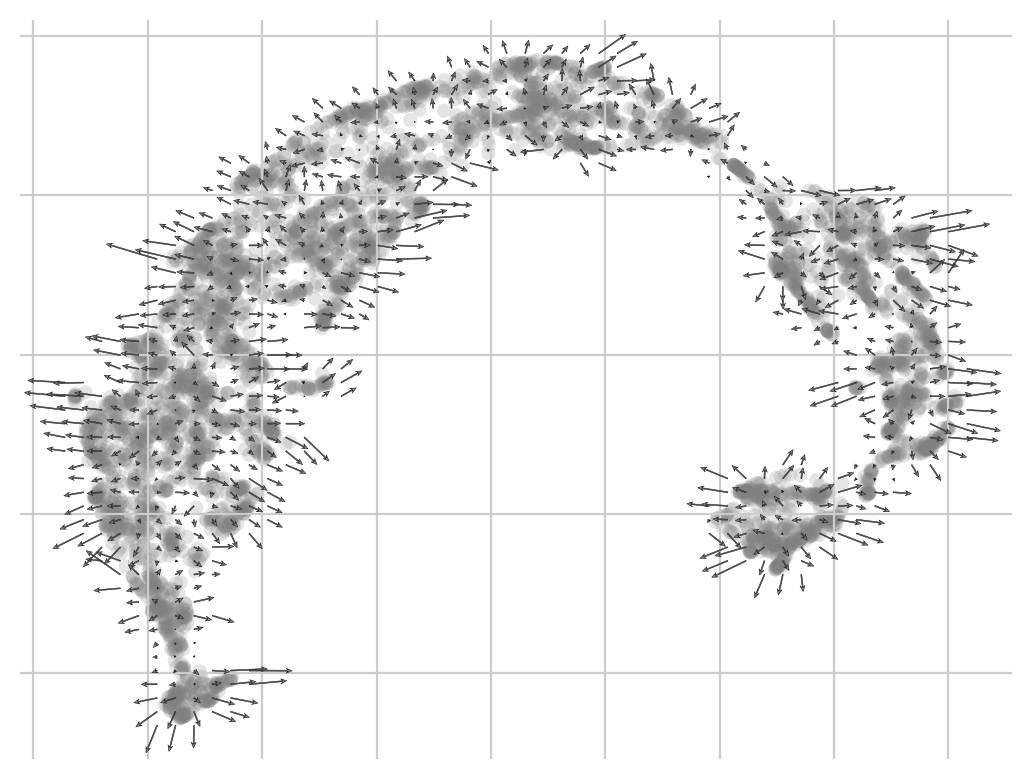

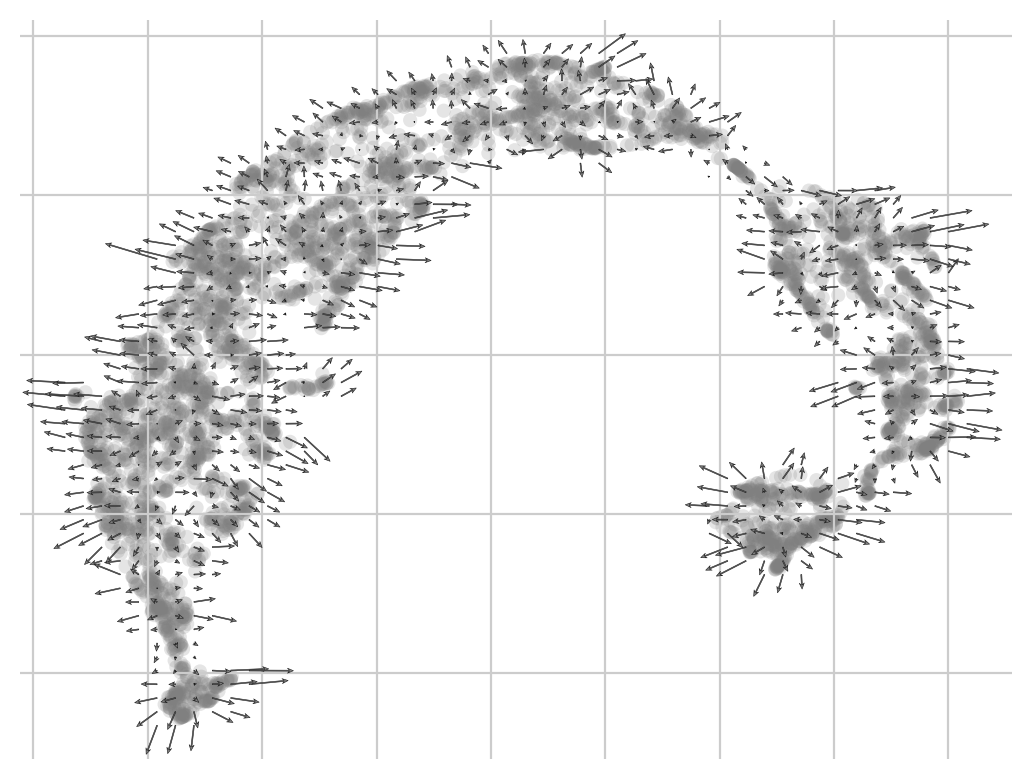

In [277]:
KO_kernel1 = cr.kernels.PrecomputedKernel(oracle.adata, obsp_key="T_fwd_meox1_KO")
KO_kernel2 = cr.kernels.PrecomputedKernel(oracle.adata, obsp_key="T_fwd_pax6a_KO")

KO_kernel1.plot_projection(basis="umap_aligned", recompute=True, stream=False, connectivities = oracle.adata.obsp["connectivities"],scale=0.5,key_added="meox1_KO_test")
KO_kernel2.plot_projection(basis="umap_aligned", recompute=True, stream=False, connectivities = oracle.adata.obsp["connectivities"],scale=0.5,key_added="pax6a_KO_test")

In [281]:
# from scipy import sparse
KO_gene = "meox1"

# Enter perturbation conditions to simulate signal propagation after the perturbation.
oracle.simulate_shift(perturb_condition={KO_gene: 0.0},
                    n_propagation=3)
# Compute the cell-cell transition probabilities for each KO gene
# Get transition probability
oracle.estimate_transition_prob(n_neighbors=200,
                                knn_random=True,
                                sampled_fraction=1)

# Calculate embedding
oracle.calculate_embedding_shift(sigma_corr=0.05)

# extract the cell-cell trans.probs
trans_prob_KO = oracle.transition_prob
# convert from dense to sparse matrix
trans_prob_KO = sparse.csr_matrix(trans_prob_KO)

# extract the 2D embedding shift (2D transition vectors, v_[i,sim])
oracle.adata.obsm[f"{KO_gene}_KO_co"] = oracle.delta_embedding


In [282]:
# from scipy import sparse
KO_gene = "pax6b"

# Enter perturbation conditions to simulate signal propagation after the perturbation.
oracle.simulate_shift(perturb_condition={KO_gene: 0.0},
                    n_propagation=3)
# Compute the cell-cell transition probabilities for each KO gene
# Get transition probability
oracle.estimate_transition_prob(n_neighbors=200,
                                knn_random=True,
                                sampled_fraction=1)

# Calculate embedding
oracle.calculate_embedding_shift(sigma_corr=0.05)

# extract the cell-cell trans.probs
trans_prob_KO = oracle.transition_prob
# convert from dense to sparse matrix
trans_prob_KO = sparse.csr_matrix(trans_prob_KO)

# extract the 2D embedding shift (2D transition vectors, v_[i,sim])
oracle.adata.obsm[f"{KO_gene}_KO_co"] = oracle.delta_embedding

meox1_KO_co


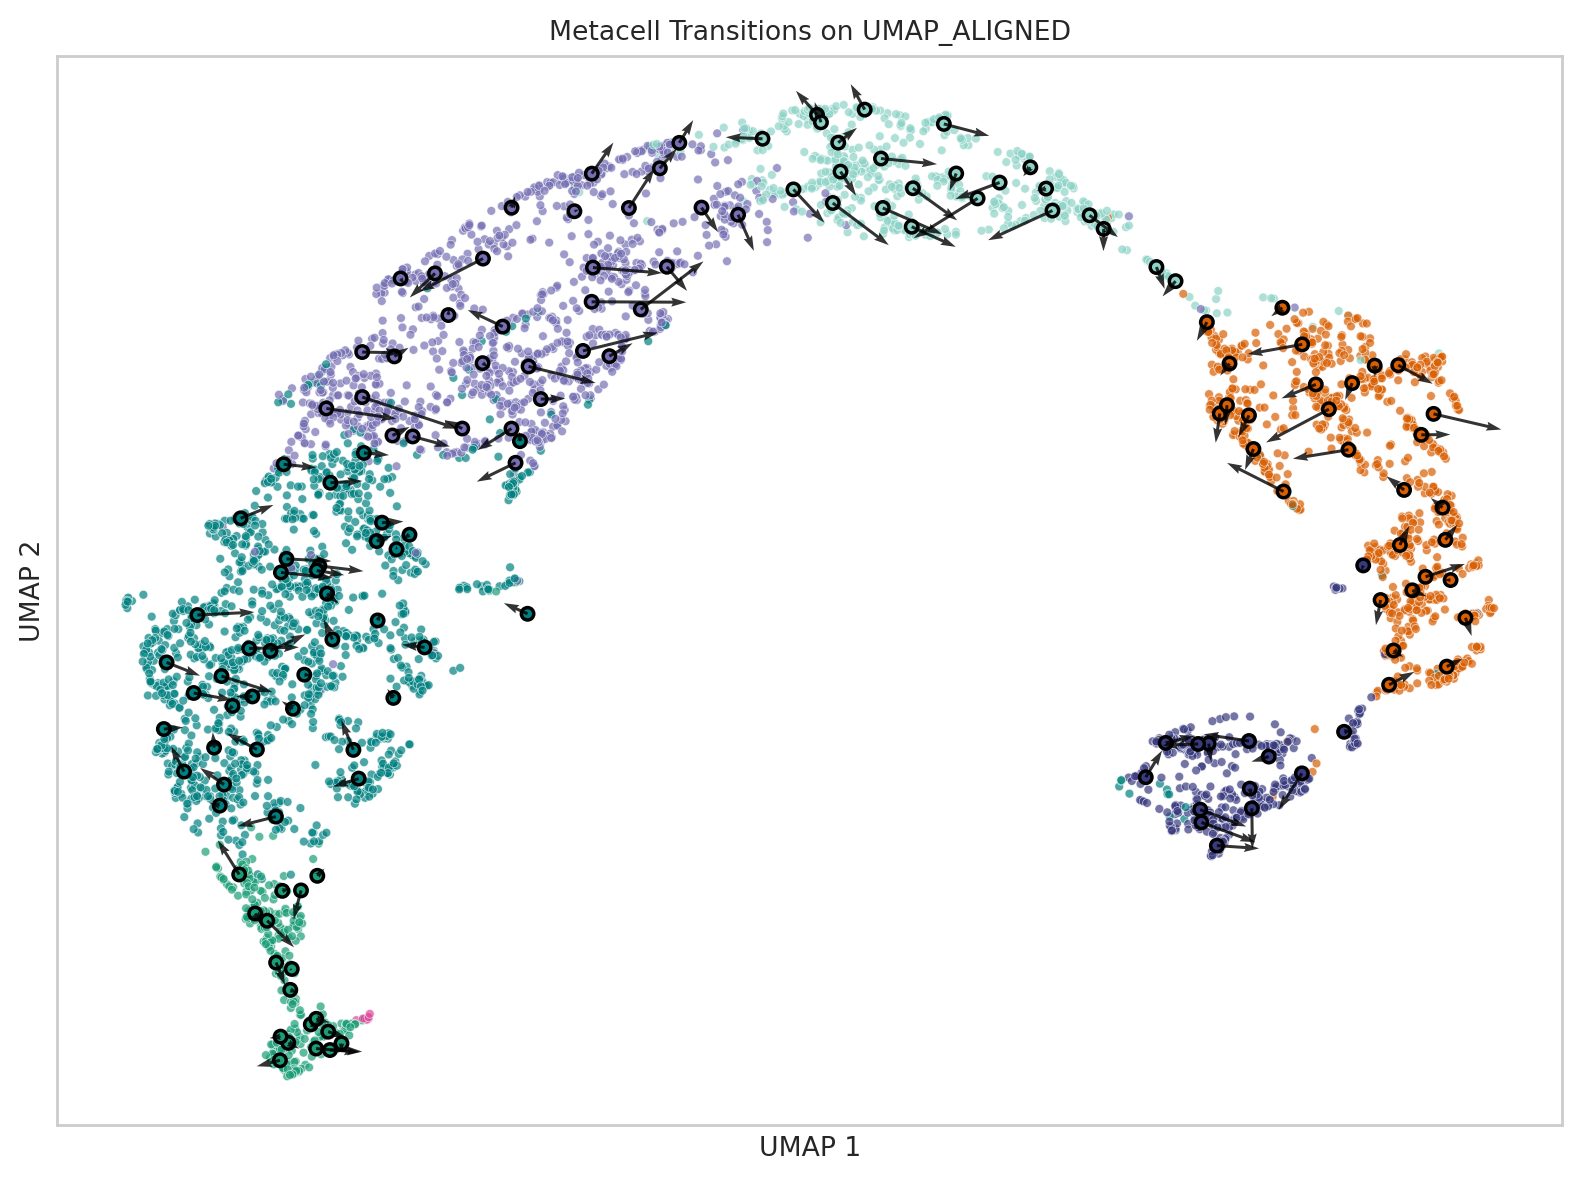

In [298]:
## repeat the above precedure for a gene KO
KO_gene = "meox1"

genotype = f"{KO_gene}_KO_co"
print(genotype)

# average the 2D embedding and 2D transition vectors across "metacells"
X_metacell, V_metacell = average_2D_trans_vecs_metacells(oracle.adata, 
                                                         metacell_col="SEACell", 
                                                         basis='umap_aligned',
                                                         key_added=genotype)

# generate the plot and save it in the folder
plot_metacell_transitions(oracle.adata, X_metacell, V_metacell,data_id="TDR126",
                            figpath=figpath,
                            metacell_col="SEACell", 
                            annotation_class="manual_annotation",
                            basis='umap_aligned', genotype=genotype,
                            arrow_scale=2.5)

pax6b_KO_co


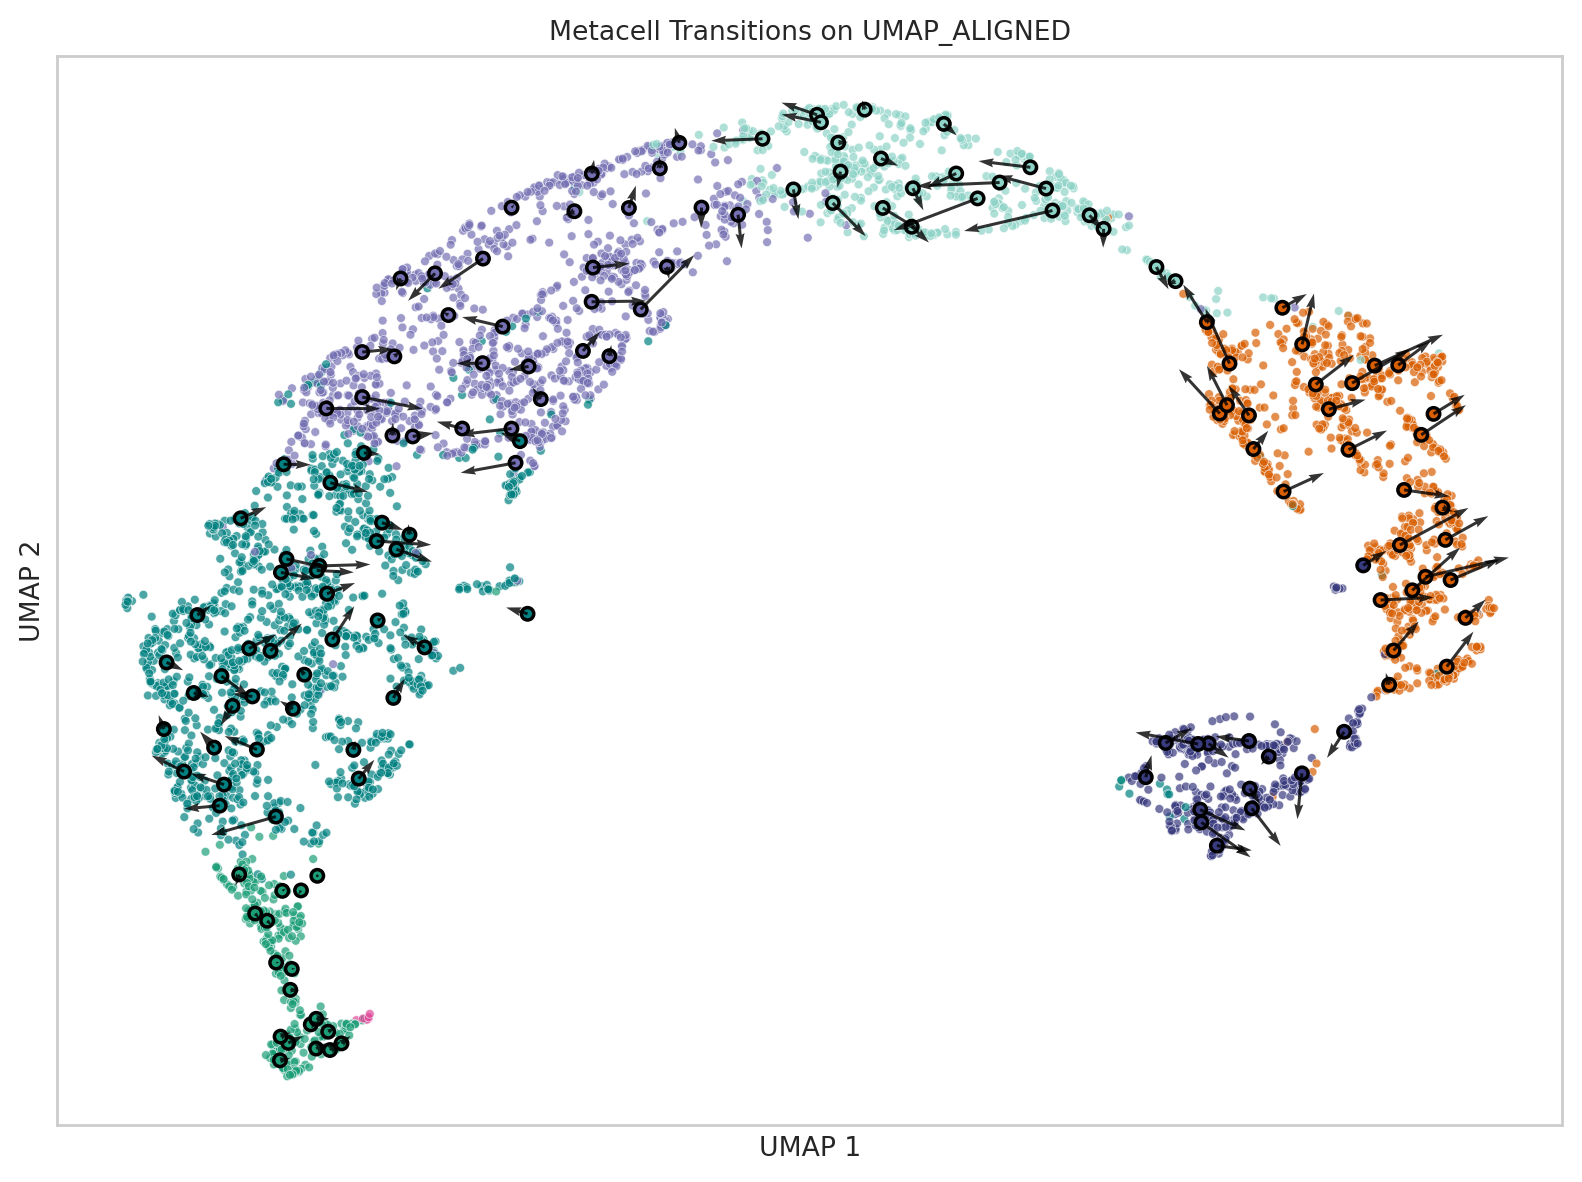

In [296]:
## repeat the above precedure for a gene KO
KO_gene = "pax6b"

genotype = f"{KO_gene}_KO_co"
print(genotype)

# average the 2D embedding and 2D transition vectors across "metacells"
X_metacell, V_metacell = average_2D_trans_vecs_metacells(oracle.adata, 
                                                         metacell_col="SEACell", 
                                                         basis='umap_aligned',
                                                         key_added=genotype)

# generate the plot and save it in the folder
plot_metacell_transitions(oracle.adata, X_metacell, V_metacell,data_id="TDR126",
                            figpath=figpath,
                            metacell_col="SEACell", 
                            annotation_class="manual_annotation",
                            basis='umap_aligned', genotype=genotype,
                            arrow_scale=2.5)

<4602x4602 sparse matrix of type '<class 'numpy.float64'>'
	with 59040 stored elements in Compressed Sparse Row format>

In [242]:
# computing the cosine similarity between 2D projected cell transition vectors (single-cell)
# between WT and KO

from sklearn.metrics.pairwise import cosine_similarity

array1 = oracle.adata.obsm["meox1_KO_umap_aligned"]
array2 = oracle.adata.obsm["pax6a_KO_umap_aligned"]

# Initialize an empty list to store cosine similarities
cosine_similarities = []

# Loop over each row and compute the cosine similarity
for row1, row2 in zip(array1, array2):
    # Reshape rows to 1x2 for cosine_similarity function
    sim = cosine_similarity(row1.reshape(1, -1), row2.reshape(1, -1))
    cosine_similarities.append(sim[0, 0])  # sim is a 1x1 array, extract the value

# Convert the list of cosine similarities into a DataFrame
cosine_df = pd.DataFrame(cosine_similarities, columns=['Cosine_Similarity'])

# Display the resulting DataFrame
print(cosine_df)

      Cosine_Similarity
0              0.999946
1              0.999770
2              0.495930
3              0.999770
4              0.993215
...                 ...
4597           0.997097
4598           0.999811
4599           0.997584
4600           0.986012
4601           0.989160

[4602 rows x 1 columns]


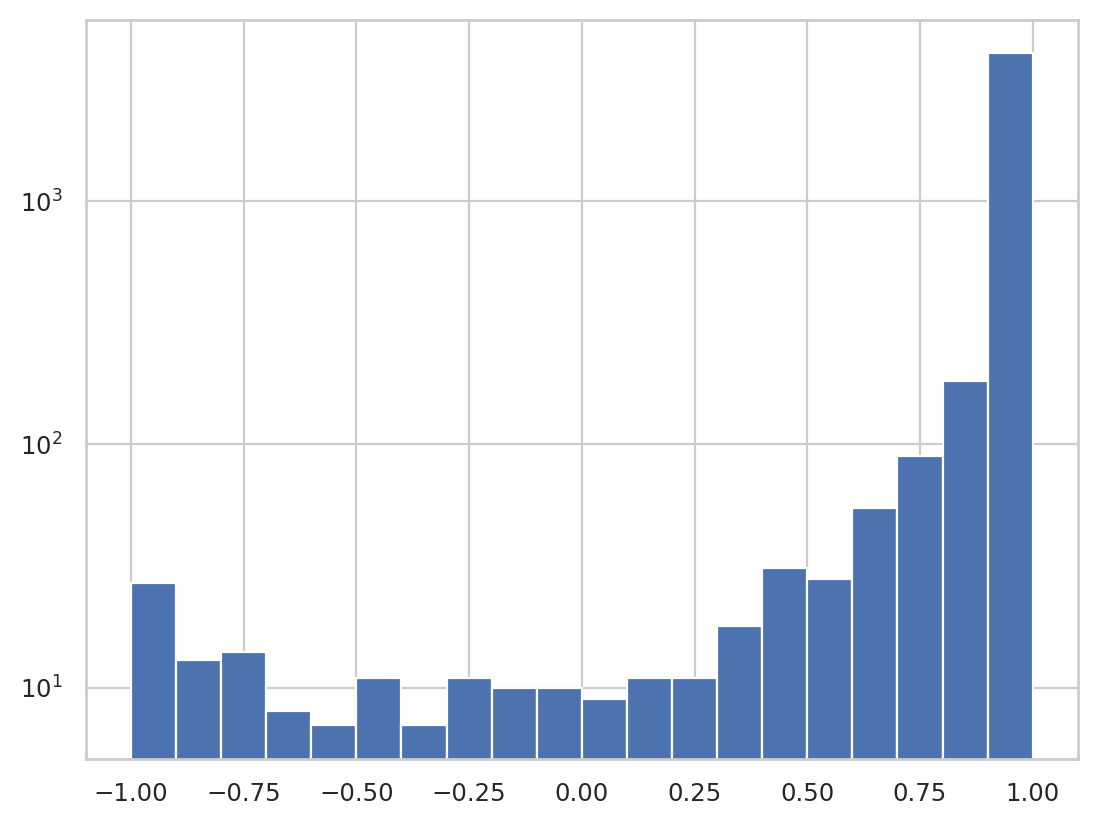

In [245]:
plt.hist(cosine_df.Cosine_Similarity, bins=20)
plt.yscale("log")
plt.show()

### Conclusion:

- From here, the single-cell level 2D transition vectors are very similar



In [ ]:
oracle.adata.obsm["meox1_KO_umap_aligned"]

In [ ]:
# Step 1: Extract the necessary data
transition_vectors = oracle.adata.obsm['transition_vectors']  # 2D vectors (n_cells x 2)
seacell_annotations = oracle.adata.obs['SEACell']  # SEACell annotations

# Step 2: Convert the transition vectors to a DataFrame for easier manipulation
transition_df = pd.DataFrame(transition_vectors, index=oracle.adata.obs_names, columns=['X_vector', 'Y_vector'])

# Step 3: Add SEACell annotations to the DataFrame
transition_df['SEACell'] = seacell_annotations

# Step 4: Group by SEACell and calculate the mean for each metacell
mean_transition_vectors = transition_df.groupby('SEACell')[['X_vector', 'Y_vector']].mean()

# Step 5: Store the averaged vectors in a new AnnData object or within the existing one
# Option 1: Store in the existing adata object
oracle.adata.obsm['metacell_transition_vectors'] = mean_transition_vectors.loc[seacell_annotations].values

# Option 2: Create a new AnnData object for metacells
import scanpy as sc

# Create a new AnnData object for metacells
metacell_adata = sc.AnnData(X=mean_transition_vectors.values)
metacell_adata.obs['SEACell'] = mean_transition_vectors.index

ved_KO


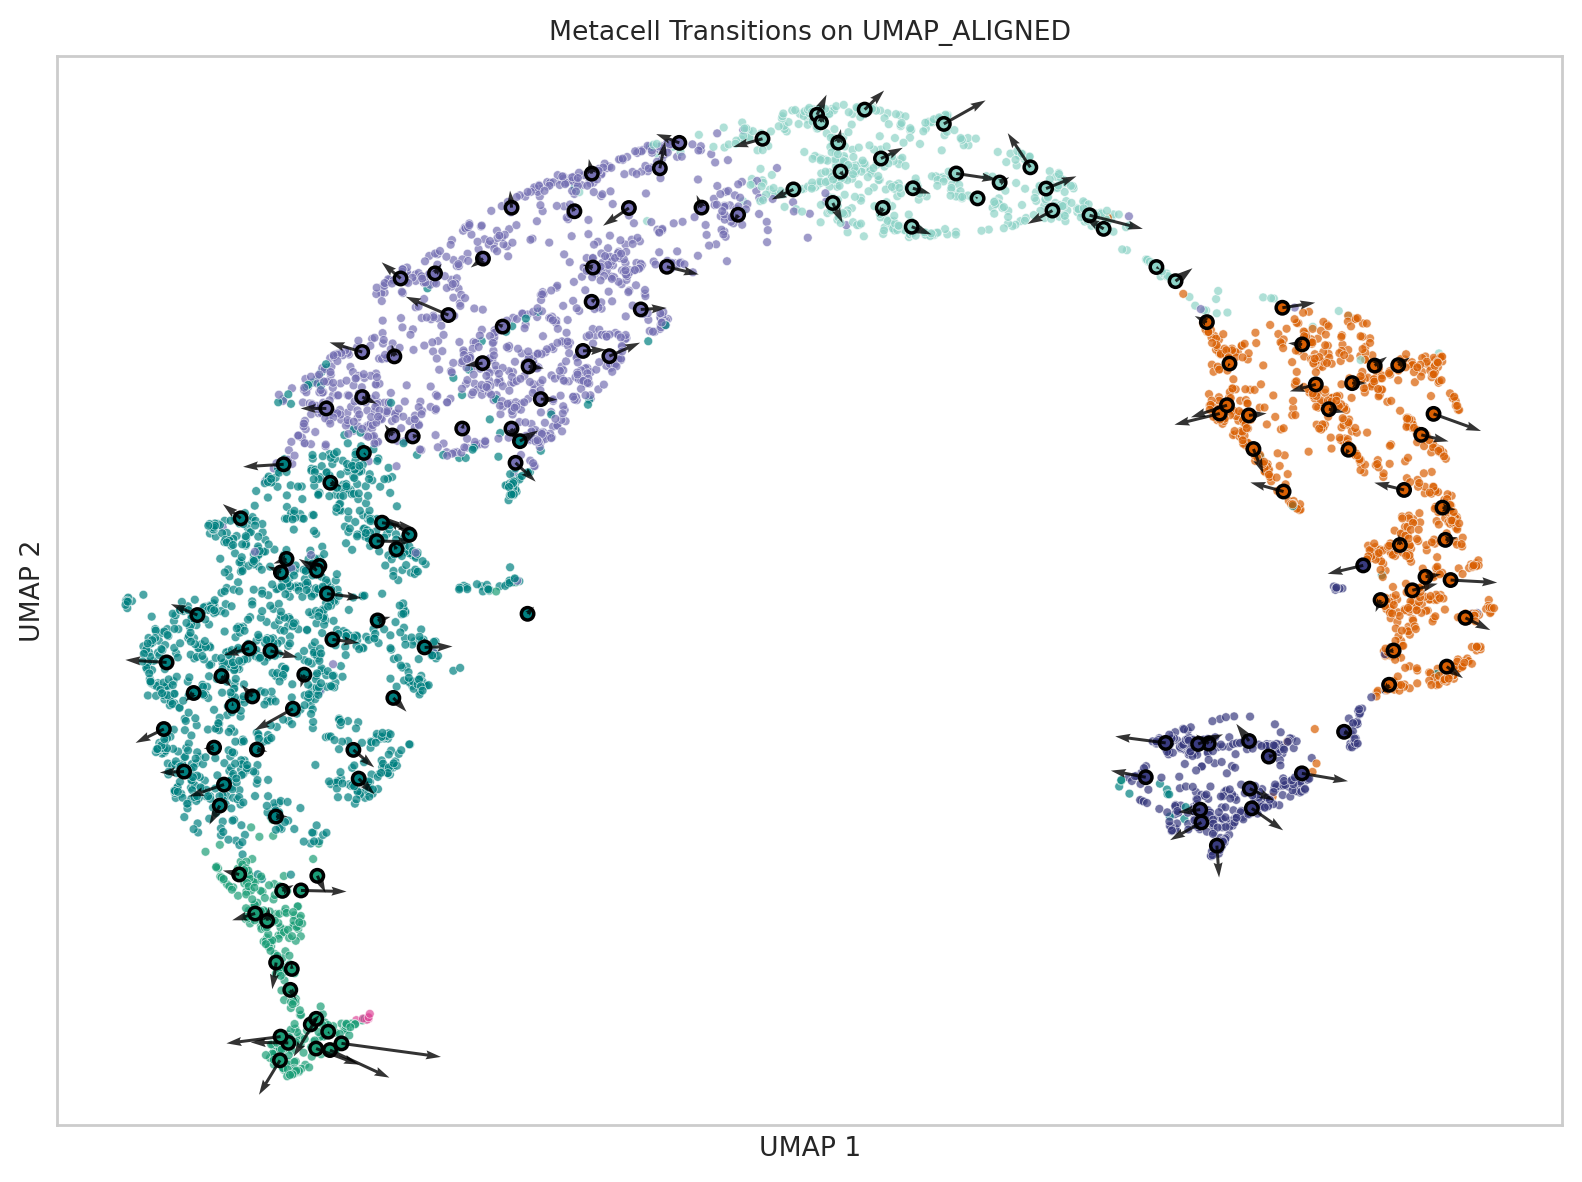

In [165]:
## repeat the above precedure for a gene KO
KO_gene = "ved"

genotype = f"{KO_gene}_KO"
print(genotype)

# average the 2D embedding and 2D transition vectors across "metacells"
X_metacell, V_metacell = average_2D_trans_vecs_metacells(oracle.adata, 
                                                         metacell_col="SEACell", 
                                                         basis='umap_aligned',
                                                         key_added=genotype)

# generate the plot and save it in the folder
plot_metacell_transitions(oracle.adata, X_metacell, V_metacell,data_id="TDR126",
                            figpath=figpath,
                            metacell_col="SEACell", 
                            annotation_class="manual_annotation",
                            basis='umap_aligned', genotype=genotype)

In [68]:
# generate the UMAP plots overlaid with 2D trans.vectors (averaged @metacell level)
for KO_gene in oracle.active_regulatory_genes:
    genotype = f"{KO_gene}_KO"

    # average the 2D embedding and 2D transition vectors across "metacells"
    X_metacell, V_metacell = average_2D_trans_vecs_metacells(oracle.adata, 
                                                             metacell_col="SEACell", 
                                                             basis='umap_aligned',
                                                             key_added=genotype)

    # generate the plot and save it in the folder
    plot_metacell_transitions(oracle.adata, X_metacell, V_metacell,data_id="TDR126",
                                figpath=figpath,
                                metacell_col="SEACell", 
                                annotation_class="manual_annotation",
                                basis='umap_aligned', genotype=genotype)

In [194]:
### make a for loop to generate the UMAP plots with transition vectors (metacell level)
list_datasets = ["TDR127","TDR128","TDR118","TDR119",
                 "TDR125","TDR124"]

for data_id in list_datasets:
    # define the figure path ({data_id} specific)
    figpath = f"/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/figures/in_silico_KO_NMPs_subsets_metacells/{data_id}/"
    # create the directory if not present already
    os.makedirs(figpath, exist_ok=True)

    # load the Oracle object
    oracle = co.load_hdf5(f"/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/09_NMPs_subsetted_v2/14_{data_id}_in_silico_KO_trans_probs_added.celloracle.oracle")
    oracle
    
    # load the metacell info
    metacell = pd.read_csv(f"/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/09_NMPs_subsetted_v2/metacells/{data_id}_seacells_obs_manual_annotation_30cells.csv", index_col=0)
    metacell.head()

    # make a dict - keys=cell_id : values=SEACEll
    metacell_dict = metacell.SEACell.to_dict()
    
    # add the metacell information to the oracle.adata
    oracle.adata.obs["SEACell"] = oracle.adata.obs_names.map(metacell_dict)
    oracle.adata.obs.head()
    
    # generate the UMAP plots overlaid with 2D trans.vectors (averaged @metacell level, WT)
    for genotype in ["WT","WT_global","WT_global_nmps"]:
        # average the 2D embedding and 2D transition vectors across "metacells"
        X_metacell, V_metacell = average_2D_trans_vecs_metacells(oracle.adata, 
                                                                 metacell_col="SEACell", 
                                                                 basis='umap_aligned',
                                                                 key_added=genotype)

        # generate the plot and save it in the folder
        plot_metacell_transitions(oracle.adata, X_metacell, V_metacell,
                                    data_id=data_id,
                                    figpath=figpath,
                                    metacell_col="SEACell", 
                                    annotation_class="manual_annotation",
                                    basis='umap_aligned', genotype=genotype)
    
    # generate the UMAP plots overlaid with 2D trans.vectors (averaged @metacell level)
    for KO_gene in oracle.active_regulatory_genes:
        genotype = f"{KO_gene}_KO"

        # average the 2D embedding and 2D transition vectors across "metacells"
        X_metacell, V_metacell = average_2D_trans_vecs_metacells(oracle.adata, 
                                                                 metacell_col="SEACell", 
                                                                 basis='umap_aligned',
                                                                 key_added=genotype)

        # generate the plot and save it in the folder
        plot_metacell_transitions(oracle.adata, X_metacell, V_metacell,
                                    data_id=data_id,
                                    figpath=figpath,
                                    metacell_col="SEACell", 
                                    annotation_class="manual_annotation",
                                    basis='umap_aligned', genotype=genotype)
        
    print(f"{data_id} is completed")

TDR127 is completed
TDR128 is completed
TDR118 is completed
TDR119 is completed
TDR125 is completed
TDR124 is completed


### step 3. quantify the effect of perturbation
### 3-1. generate celltype-celltype trans.probs matrices


- idea is illustrated in detail in the methods section.

- we're quantifying the effect of perturbation using the cosine similarity between celltype-celltype transition probabilities between "WT", and "KO" cases.



In [71]:
oracle.adata.obsp["T_fwd_WT"]

<4602x4602 sparse matrix of type '<class 'numpy.float64'>'
	with 60186 stored elements in Compressed Sparse Row format>

In [ ]:
# # Step 1: Create a mapping from SEACell to celltype
# seacell_to_celltype = df.set_index('SEACell')['celltype'].to_dict()

# # Step 2: Get unique celltypes
# celltypes = df['manual_annotation'].unique()

# # Step 3: Create an empty celltype transition matrix
# celltype_trans_probs = pd.DataFrame(0, index=celltypes, columns=celltypes)

# # Step 4: Fill the celltype transition matrix
# for i, source_metacell in enumerate(metacell_trans_probs.index):
#     source_celltype = seacell_to_celltype[source_metacell]
#     for j, target_metacell in enumerate(metacell_trans_probs.columns):
#         target_celltype = seacell_to_celltype[target_metacell]
#         celltype_trans_probs.loc[source_celltype, target_celltype] += metacell_trans_probs.iloc[i, j]

# # Step 5: Normalize the celltype transition matrix
# celltype_trans_probs = celltype_trans_probs.div(celltype_trans_probs.sum(axis=1), axis=0)


In [113]:
oracle.adata.obs.SEACell

AAACAGCCAACACTTG-1_5     SEACell-35
AAACAGCCACAATGCC-1_5     SEACell-93
AAACAGCCACCTGGTG-1_5    SEACell-151
AAACAGCCAGTTATCG-1_5     SEACell-13
AAACATGCAAACTGCC-1_5    SEACell-130
                           ...     
TTTGTTGGTAACGTGC-1_5    SEACell-111
TTTGTTGGTCCTAAGA-1_5    SEACell-132
TTTGTTGGTCTCAGCC-1_5     SEACell-60
TTTGTTGGTGAGCAAG-1_5    SEACell-137
TTTGTTGGTGCATCGG-1_5     SEACell-62
Name: SEACell, Length: 4602, dtype: object

In [109]:
def compute_celltype_transitions(adata, trans_key="T_fwd_WT", celltype_key="manual_annotation"):
    # Get the cell-cell transition matrix
    T_cell = adata.obsp[trans_key]
    
    # Get celltype labels
    celltypes = adata.obs[celltype_key]
    
    # Get unique celltypes
    unique_celltypes = celltypes.cat.categories
    
    # Initialize the celltype transition matrix
    n_celltypes = len(unique_celltypes)
    T_celltype = np.zeros((n_celltypes, n_celltypes))
    
    # Create a mapping of celltype to cell indices
    celltype_to_indices = {ct: np.where(celltypes == ct)[0] for ct in unique_celltypes}
    
    # Compute celltype transitions
    for i, source_type in enumerate(unique_celltypes):
        source_indices = celltype_to_indices[source_type]
        for j, target_type in enumerate(unique_celltypes):
            target_indices = celltype_to_indices[target_type]
            
            # Extract the submatrix of transitions from source to target celltype
            submatrix = T_cell[source_indices][:, target_indices]
            
            # Sum all transitions and normalize by the number of source cells
            T_celltype[i, j] = submatrix.sum() / len(source_indices)
    
    # Create a DataFrame for easier interpretation
    T_celltype_df = pd.DataFrame(T_celltype, index=unique_celltypes, columns=unique_celltypes)
    
    # Normalize rows to sum to 1
    T_celltype_df = T_celltype_df.div(T_celltype_df.sum(axis=1), axis=0)
    
    return T_celltype_df
# Usage
celltype_transitions = compute_celltype_transitions(oracle.adata)
celltype_transitions
# # Visualize the result
# import matplotlib.pyplot as plt
# import seaborn as sns

# plt.figure(figsize=(12, 10))
# sns.heatmap(celltype_transitions, annot=True, cmap='YlOrRd', fmt='.2f')
# plt.title('Celltype-to-Celltype Transition Probabilities')
# plt.tight_layout()
# plt.show()

NMPs       PSM  fast_muscle  neural_posterior   somites  \
NMPs              0.920365  0.001569     0.000000          0.000128  0.000127   
PSM               0.000482  0.938699     0.000308          0.003514  0.013898   
fast_muscle       0.000000  0.059692     0.403989          0.000000  0.506897   
neural_posterior  0.000000  0.009691     0.000000          0.963516  0.001113   
somites           0.000000  0.036102     0.006838          0.002155  0.954463   
spinal_cord       0.008014  0.001581     0.000065          0.018228  0.000106   
tail_bud          0.018115  0.071434     0.000196          0.001491  0.000267   

                  spinal_cord  tail_bud  
NMPs                 0.021498  0.056313  
PSM                  0.002272  0.040826  
fast_muscle          0.000000  0.029422  
neural_posterior     0.022656  0.003023  
somites              0.000000  0.000442  
spinal_cord          0.969322  0.002684  
tail_bud             0.003483  0.905013

In [110]:
np.sum(celltype_transitions,1)

NMPs                1.0
PSM                 1.0
fast_muscle         1.0
neural_posterior    1.0
somites             1.0
spinal_cord         1.0
tail_bud            1.0
dtype: float64

In [81]:
def compute_row_cosine_similarities(df_wt, df_ko):
    """
    Compute cosine similarities between corresponding rows of two dataframes.
    
    Parameters:
    df_wt (pd.DataFrame): Transition probability matrix for WT
    df_ko (pd.DataFrame): Transition probability matrix for KO
    
    Returns:
    pd.Series: Cosine similarities for each row
    """
    # Ensure both dataframes have the same index and columns
    assert df_wt.index.equals(df_ko.index), "Dataframes must have the same index"
    assert df_wt.columns.equals(df_ko.columns), "Dataframes must have the same columns"
    
    similarities = {}
    for idx in df_wt.index:
        wt_row = df_wt.loc[idx].values
        ko_row = df_ko.loc[idx].values
        
        # Compute cosine similarity (1 - cosine distance)
        similarity = 1 - cosine(wt_row, ko_row)
        similarities[idx] = similarity
    
    return pd.Series(similarities, name="cos_sim")

# Assuming you have your dataframes loaded as df_wt and df_ko
# df_wt = pd.read_csv('wt_transitions.csv', index_col=0)
# df_ko = pd.read_csv('ko_transitions.csv', index_col=0)

# Compute cosine similarities
# cosine_similarities = compute_row_cosine_similarities(df_wt, df_ko)

In [82]:
# generate the UMAP plots overlaid with 2D trans.vectors (averaged @metacell level)

# average the 2D embedding and 2D transition vectors across "metacells"
trans_probs_ct_WT = compute_celltype_transitions(oracle.adata, trans_key="T_fwd_WT", 
                                 celltype_key="manual_annotation")

trans_probs_ct_KO = compute_celltype_transitions(oracle.adata, trans_key="T_fwd_meox1_KO", 
                                 celltype_key="manual_annotation")

cosine_similarities = compute_row_cosine_similarities(trans_probs_ct_WT, trans_probs_ct_KO)
cosine_similarities

NMPs                0.999609
PSM                 0.998941
fast_muscle         0.793341
neural_posterior    0.999140
somites             0.990574
spinal_cord         0.999995
tail_bud            0.999371
Name: cos_sim, dtype: float64

In [84]:
# average the 2D embedding and 2D transition vectors across "metacells"
trans_probs_ct_WT = compute_celltype_transitions(oracle.adata, trans_key="T_fwd_WT", 
                                 celltype_key="manual_annotation")

# Initialize an empty DataFrame with celltypes as the index
celltypes = trans_probs_ct_WT.index
cosine_sim_df = pd.DataFrame(index=celltypes)

# Compute cosine similarities for each gene knockout
for gene in oracle.active_regulatory_genes:
    # Compute transition probabilities for the current gene knockout
    trans_key = f"T_fwd_{gene}_KO"
    trans_probs_ct_KO = compute_celltype_transitions(oracle.adata, trans_key=trans_key, 
                                                     celltype_key="manual_annotation")
    
    # Compute cosine similarities
    cosine_similarities = compute_row_cosine_similarities(trans_probs_ct_WT, trans_probs_ct_KO)
    
    # Add the cosine similarities as a new column to the DataFrame
    cosine_sim_df[gene] = cosine_similarities

# Display the resulting DataFrame
print(cosine_sim_df)

                   arntl1b      arxb    atoh1a   barhl1a     barx2   bcl11aa  \
NMPs              0.999796  0.999804  0.999797  0.999798  0.999798  0.999795   
PSM               0.999369  0.999386  0.999358  0.999281  0.999357  0.999364   
fast_muscle       0.797091  0.797457  0.796945  0.797466  0.796945  0.797392   
neural_posterior  0.998851  0.998911  0.998863  0.998928  0.998860  0.998759   
somites           0.997627  0.997590  0.997658  0.997679  0.997686  0.997660   
spinal_cord       0.999931  0.999954  0.999933  0.999905  0.999933  0.999927   
tail_bud          0.999479  0.999477  0.999424  0.999368  0.999424  0.999413   

                   bcl11ab   bhlha15      cdx4     cebpb  ...       ved  \
NMPs              0.999797  0.999797  0.999482  0.999792  ...  0.999665   
PSM               0.999358  0.999358  0.999614  0.999370  ...  0.999785   
fast_muscle       0.796966  0.796945  0.794680  0.796717  ...  0.795612   
neural_posterior  0.998851  0.998858  0.999098  0.998830  .

In [90]:
cosine_sim_df.loc["somites"].sort_values(ascending=False)

rarga     0.999686
vent      0.999630
eve1      0.999488
tbx16     0.999337
mespab    0.999269
            ...   
pax3a     0.988509
nr2f5     0.986659
meis2a    0.986507
rxraa     0.986086
meis3     0.984364
Name: somites, Length: 241, dtype: float64

In [94]:
def get_top_genes_for_celltype(df, celltype, n=10):
    """
    Get the top n genes with the lowest cosine similarity scores for a given celltype.
    
    Parameters:
    df (pd.DataFrame): The cosine similarity DataFrame
    celltype (str): The celltype to analyze
    n (int): Number of top genes to return (default 10)
    
    Returns:
    pd.Series: Top n genes with their scores, sorted from lowest to highest
    """
    # Sort the row for the given celltype
    sorted_genes = df.loc[celltype].sort_values()
    
    # Return the top n genes
    return sorted_genes.head(n)

# Example usage:
celltype = "fast_muscle"  # Replace with your celltype of interest
top_genes = get_top_genes_for_celltype(cosine_sim_df, celltype, n=20)

print(f"Top 20 genes with lowest cosine similarity for {celltype}:")
print(top_genes)

Top 20 genes with lowest cosine similarity for fast_muscle:
mef2d     0.789883
hmga1a    0.790758
dmrt2a    0.790916
meis1a    0.791727
meox1     0.793341
zbtb18    0.793422
dlx3b     0.793541
foxp4     0.793935
stat5a    0.794028
foxd5     0.794038
zic2b     0.794083
sox11a    0.794178
sox19a    0.794480
cdx4      0.794680
zic3      0.794946
rxraa     0.795140
snai1a    0.795248
six1b     0.795340
hoxa9a    0.795398
her6      0.795492
Name: fast_muscle, dtype: float64


In [95]:
# Example usage:
celltype = "somites"  # Replace with your celltype of interest
top_genes = get_top_genes_for_celltype(cosine_sim_df, celltype, n=20)

print(f"Top 20 genes with lowest cosine similarity for {celltype}:")
print(top_genes)

Top 20 genes with lowest cosine similarity for somites:
meis3      0.984364
rxraa      0.986086
meis2a     0.986507
nr2f5      0.986659
pax3a      0.988509
pax7b      0.988926
meis1a     0.989514
dmrt2a     0.990476
meox1      0.990574
pbx1b      0.992791
foxd2      0.992830
rxrgb      0.993892
tead1b     0.993915
six1b      0.994357
foxp4      0.994795
uncx4.1    0.994818
hey1       0.995221
zbtb18     0.995268
foxc1b     0.995808
foxd3      0.996099
Name: somites, dtype: float64


In [99]:
# Example usage:
celltype = "spinal_cord"  # Replace with your celltype of interest
top_genes = get_top_genes_for_celltype(cosine_sim_df, celltype, n=20)

print(f"Top 20 genes with lowest cosine similarity for {celltype}:")
print(top_genes)

Top 20 genes with lowest cosine similarity for spinal_cord:
pax6b      0.999471
sox13      0.999567
pax6a      0.999596
foxp4      0.999706
rfx4       0.999707
meis3      0.999781
pax3a      0.999798
thrab      0.999802
sp9        0.999819
gbx1       0.999827
gli3       0.999868
meis2a     0.999888
pnx        0.999893
smad3a     0.999894
etv5a      0.999895
klf7a      0.999898
barhl1a    0.999905
pbx1b      0.999909
tead1b     0.999909
esrrga     0.999910
Name: spinal_cord, dtype: float64


#### Conclusion

When we coarse-grained everything at the celltype level, then the transition probabilities between WT and KO becomes very subtle - this could be problematic when we "score" the TFs for their strength of KO.

## step 3. (Continued) quantify the effect of perturbation
### 3-2. generate metacell-metacell trans.probs matrices


- idea is illustrated in detail in the methods section.

- we're quantifying the effect of perturbation using the cosine similarity between celltype-celltype transition probabilities between "WT", and "KO" cases.


In [114]:
def compute_metacell_transitions(adata, trans_key="T_fwd_WT", metacell_key="SEACell"):
    # Get the cell-cell transition matrix
    T_cell = adata.obsp[trans_key]
    
    # Get metacell labels
    metacells = adata.obs[metacell_key]
    
    # Get unique metacells
    unique_metacells = metacells.unique()
    
    # Initialize the metacell transition matrix
    n_metacells = len(unique_metacells)
    T_metacell = np.zeros((n_metacells, n_metacells))
    
    # Create a mapping of metacell to cell indices
    metacell_to_indices = {mc: np.where(metacells == mc)[0] for mc in unique_metacells}
    
    # Compute metacell transitions
    for i, source_metacell in enumerate(unique_metacells):
        source_indices = metacell_to_indices[source_metacell]
        for j, target_metacell in enumerate(unique_metacells):
            target_indices = metacell_to_indices[target_metacell]
            
            # Extract the submatrix of transitions from source to target metacell
            submatrix = T_cell[source_indices][:, target_indices]
            
            # Sum all transitions and normalize by the number of source cells
            T_metacell[i, j] = submatrix.sum() / len(source_indices)
    
    # Create a DataFrame for easier interpretation
    T_metacell_df = pd.DataFrame(T_metacell, index=unique_metacells, columns=unique_metacells)
    
    # Normalize rows to sum to 1
    T_metacell_df = T_metacell_df.div(T_metacell_df.sum(axis=1), axis=0)
    
    return T_metacell_df

# Usage
metacell_transitions = compute_metacell_transitions(oracle.adata)

In [117]:
metacell_transitions

SEACell-35  SEACell-93  SEACell-151  SEACell-13  SEACell-130  \
SEACell-35     0.628606    0.000000     0.000000    0.000000     0.000000   
SEACell-93     0.000000    0.692362     0.000000    0.000000     0.000000   
SEACell-151    0.000000    0.000000     0.790293    0.000000     0.000000   
SEACell-13     0.000000    0.000000     0.000000    0.690983     0.000000   
SEACell-130    0.000000    0.000000     0.000000    0.000000     0.670239   
...                 ...         ...          ...         ...          ...   
SEACell-36     0.000000    0.000000     0.000000    0.000000     0.000000   
SEACell-7      0.000000    0.000000     0.000000    0.000000     0.000000   
SEACell-92     0.000000    0.000000     0.000000    0.000000     0.000000   
SEACell-27     0.000000    0.000000     0.000000    0.000000     0.000000   
SEACell-0      0.000000    0.000000     0.000000    0.000000     0.000000   

             SEACell-70  SEACell-127  SEACell-134  SEACell-87  SEACell-102  \
SEACell-35       0.0000          0.0     0.000000    0.047156     0.000000   
SEACell-93       0.0000          0.0     0.000000    0.000000     0.000000   
SEACell-151      0.0000          0.0     0.000000    0.000000     0.000000   
SEACell-13       0.0000          0.0     0.005042    0.000000     0.000000   
SEACell-130      0.0000          0.0     0.000000    0.000000     0.005761   
...                 ...          ...          ...         ...          ...   
SEACell-36       0.0491          0.0     0.036924    0.000000     0.000000   
SEACell-7        0.0000          0.0     0.000000    0.000000     0.000000   
SEACell-92       0.0000          0.0     0.000000    0.000000     0.000000   
SEACell-27       0.0000          0.0     0.010055    0.000000     0.000000   
SEACell-0        0.0000          0.0     0.000000    0.000000     0.000000   

             ...  SEACell-86  SEACell-105  SEACell-142  SEACell-122  \
SEACell-35   ...    0.000000          0.0          0.0          0.0   
SEACell-93   ...    0.073505          0.0          0.0          0.0   
SEACell-151  ...    0.000000          0.0          0.0          0.0   
SEACell-13   ...    0.000000          0.0          0.0          0.0   
SEACell-130  ...    0.000000          0.0          0.0          0.0   
...          ...         ...          ...          ...          ...   
SEACell-36   ...    0.000000          0.0          0.0          0.0   
SEACell-7    ...    0.000000          0.0          0.0          0.0   
SEACell-92   ...    0.000000          0.0          0.0          0.0   
SEACell-27   ...    0.000000          0.0          0.0          0.0   
SEACell-0    ...    0.000000          0.0          0.0          0.0   

             SEACell-77  SEACell-36  SEACell-7  SEACell-92  SEACell-27  \
SEACell-35     0.000000    0.000000   0.000000    0.000000    0.000000   
SEACell-93     0.000000    0.000000   0.000000    0.000000    0.000000   
SEACell-151    0.000000    0.000000   0.000000    0.000000    0.000000   
SEACell-13     0.000000    0.000000   0.000000    0.000000    0.000000   
SEACell-130    0.000000    0.000000   0.000000    0.000000    0.000000   
...                 ...         ...        ...         ...         ...   
SEACell-36     0.000593    0.669479   0.000000    0.000000    0.000000   
SEACell-7      0.000000    0.000000   0.606986    0.000000    0.000000   
SEACell-92     0.000000    0.000000   0.000000    0.704940    0.000000   
SEACell-27     0.000000    0.000000   0.000000    0.000000    0.689276   
SEACell-0      0.000000    0.000000   0.000000    0.034668    0.000000   

             SEACell-0  
SEACell-35    0.000000  
SEACell-93    0.000000  
SEACell-151   0.000000  
SEACell-13    0.000000  
SEACell-130   0.000000  
...                ...  
SEACell-36    0.000000  
SEACell-7     0.000000  
SEACell-92    0.024155  
SEACell-27    0.000000  
SEACell-0     0.608741  

[153 rows x 153 columns]

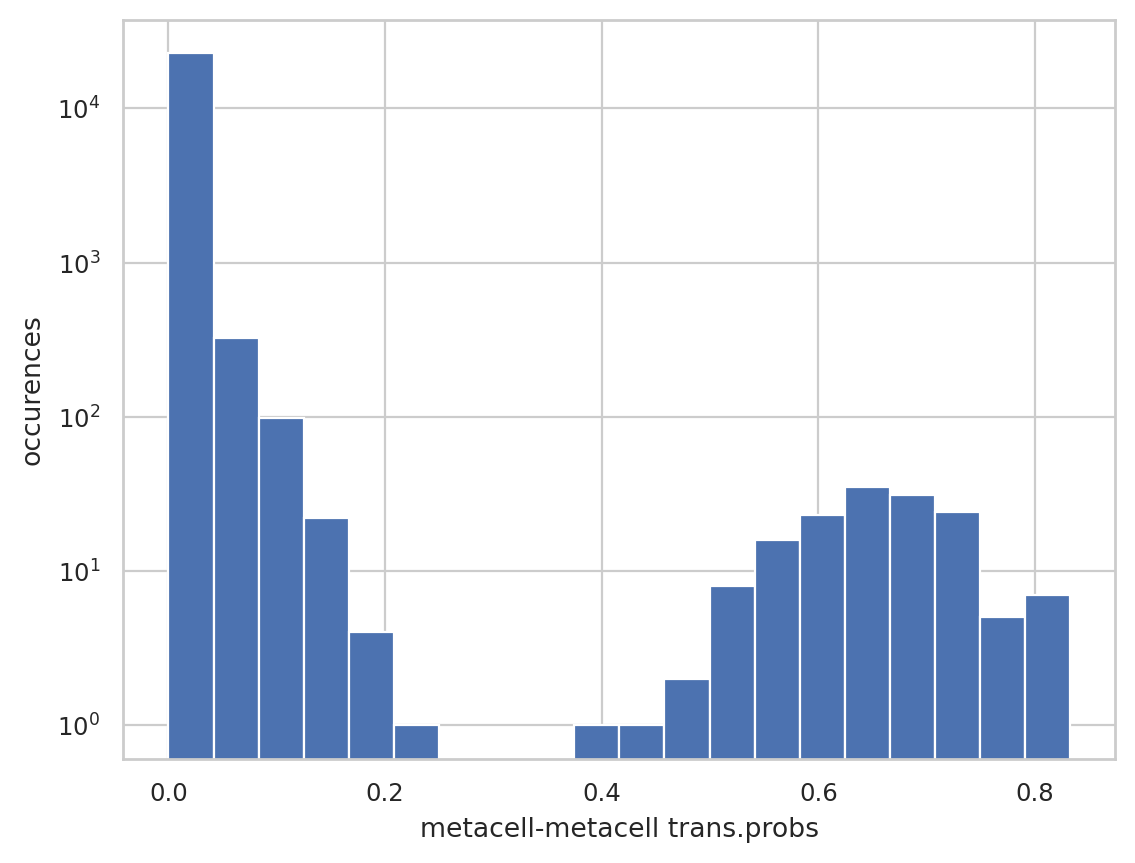

In [138]:
# plot the distribution (histogram) of metacell-metacell transition probabilities
plt.hist(metacell_transitions.values.flatten(),bins=20)
plt.yscale("log")
plt.xlabel("metacell-metacell trans.probs")
plt.ylabel("occurences")
plt.show()

In [118]:
# Calculate most prevalent cell type for each metacell
most_prevalent = oracle.adata.obs.groupby("SEACell")["manual_annotation"].agg(lambda x: x.value_counts().idxmax())
most_prevalent

SEACell
SEACell-0               somites
SEACell-1      neural_posterior
SEACell-10             tail_bud
SEACell-100                NMPs
SEACell-101                 PSM
                     ...       
SEACell-95                 NMPs
SEACell-96                 NMPs
SEACell-97          spinal_cord
SEACell-98                  PSM
SEACell-99          spinal_cord
Name: manual_annotation, Length: 153, dtype: object

In [145]:
most_prevalent.loc["SEACell-35"]

'spinal_cord'

In [126]:
most_prevalent.index

Index(['SEACell-0', 'SEACell-1', 'SEACell-10', 'SEACell-100', 'SEACell-101',
       'SEACell-102', 'SEACell-103', 'SEACell-104', 'SEACell-105',
       'SEACell-106',
       ...
       'SEACell-90', 'SEACell-91', 'SEACell-92', 'SEACell-93', 'SEACell-94',
       'SEACell-95', 'SEACell-96', 'SEACell-97', 'SEACell-98', 'SEACell-99'],
      dtype='object', name='SEACell', length=153)

In [122]:
most_prevalent.value_counts()

PSM                 38
tail_bud            31
spinal_cord         29
NMPs                23
somites             18
neural_posterior    14
Name: manual_annotation, dtype: int64

In [140]:
# compute the metacell-metacell transition probabilities for a couple of genotypes (WT and KO)
trans_probs_metacell_WT = compute_metacell_transitions(oracle.adata, trans_key="T_fwd_WT", metacell_key="SEACell")
trans_probs_metacell_meox1 = compute_metacell_transitions(oracle.adata, trans_key="T_fwd_meox1_KO", metacell_key="SEACell")



In [141]:
# average the 2D embedding and 2D transition vectors across "metacells"
trans_probs_metacell_WT = compute_metacell_transitions(oracle.adata, 
                                                       trans_key="T_fwd_WT", 
                                                       metacell_key="SEACell")


# Initialize an empty DataFrame with celltypes as the index
metacells = trans_probs_metacell_WT.index
cosine_sim_df = pd.DataFrame(index=metacells)

# Compute cosine similarities for each gene knockout
for gene in oracle.active_regulatory_genes:
    # Compute transition probabilities for the current gene knockout
    trans_key = f"T_fwd_{gene}_KO"
    trans_probs_metacell_KO = compute_metacell_transitions(oracle.adata, trans_key=trans_key, 
                                                             metacell_key="SEACell")
    
    # Compute cosine similarities
    cosine_similarities = compute_row_cosine_similarities(trans_probs_metacell_WT, trans_probs_metacell_KO)
    
    # Add the cosine similarities as a new column to the DataFrame
    cosine_sim_df[gene] = cosine_similarities

# Display the resulting DataFrame
cosine_sim_df

              arntl1b      arxb    atoh1a   barhl1a     barx2   bcl11aa  \
SEACell-35   0.588534  0.670341  0.587516  0.547354  0.584949  0.581425   
SEACell-93   0.734645  0.731579  0.728069  0.727458  0.729021  0.729482   
SEACell-151  0.462653  0.501094  0.466930  0.470235  0.467405  0.436312   
SEACell-13   0.555603  0.555152  0.556407  0.561546  0.556854  0.556092   
SEACell-130  0.410313  0.398547  0.459787  0.478723  0.461905  0.465883   
...               ...       ...       ...       ...       ...       ...   
SEACell-36   0.254369  0.252435  0.280012  0.285651  0.280078  0.282153   
SEACell-7    0.572380  0.547966  0.551588  0.564600  0.551693  0.559326   
SEACell-92   0.333149  0.383279  0.368792  0.350992  0.368921  0.362634   
SEACell-27   0.549285  0.552310  0.524341  0.520404  0.524174  0.522891   
SEACell-0    0.254218  0.306317  0.285746  0.269718  0.285746  0.278665   

              bcl11ab   bhlha15      cdx4     cebpb  ...       ved      vent  \
SEACell-35   0.5875

In [326]:
# Prepare data for plotting
adata = oracle.adata
basis = "umap_aligned"
metacell_col = "SEACell"
annotation_class = "manual_annotation"
cell_size = 10


umap_coords = pd.DataFrame(adata.obsm[f'X_{basis}'], columns=[0, 1], index=adata.obs_names)
umap_data = umap_coords.join(adata.obs[[metacell_col, annotation_class]])
umap_data = umap_data.rename(columns={annotation_class: 'celltype'})

# # Plot single cells
# sns.scatterplot(
#     x=0, y=1, hue='celltype', data=umap_data, s=cell_size, 
#     palette=cell_type_color_dict, legend=None, ax=ax, alpha=0.7
# )

# Calculate most prevalent cell type for each metacell
most_prevalent = adata.obs.groupby(metacell_col)[annotation_class].agg(lambda x: x.value_counts().idxmax())

# Prepare metacell data
mcs = umap_data.groupby(metacell_col).mean().reset_index()
mcs['celltype'] = most_prevalent.values

In [330]:
# mcs.set_index("SEACell", inplace=True)
mcs

0          1          celltype
SEACell                                           
SEACell-0   -4.982382 -10.875516           somites
SEACell-1    4.864808  -6.030067  neural_posterior
SEACell-10  -2.220111   6.977355          tail_bud
SEACell-100  2.584591   7.588412              NMPs
SEACell-101 -4.977729   1.198668               PSM
...               ...        ...               ...
SEACell-95   3.600979   6.891808              NMPs
SEACell-96   2.335806   7.250861              NMPs
SEACell-97   4.926554   4.617297       spinal_cord
SEACell-98  -4.265985  -3.380911               PSM
SEACell-99   7.396784  -0.802890       spinal_cord

[153 rows x 3 columns]

In [331]:
cosine_sim_df

arntl1b      arxb    atoh1a   barhl1a     barx2   bcl11aa  \
SEACell-35   0.588534  0.670341  0.587516  0.547354  0.584949  0.581425   
SEACell-93   0.734645  0.731579  0.728069  0.727458  0.729021  0.729482   
SEACell-151  0.462653  0.501094  0.466930  0.470235  0.467405  0.436312   
SEACell-13   0.555603  0.555152  0.556407  0.561546  0.556854  0.556092   
SEACell-130  0.410313  0.398547  0.459787  0.478723  0.461905  0.465883   
...               ...       ...       ...       ...       ...       ...   
SEACell-36   0.254369  0.252435  0.280012  0.285651  0.280078  0.282153   
SEACell-7    0.572380  0.547966  0.551588  0.564600  0.551693  0.559326   
SEACell-92   0.333149  0.383279  0.368792  0.350992  0.368921  0.362634   
SEACell-27   0.549285  0.552310  0.524341  0.520404  0.524174  0.522891   
SEACell-0    0.254218  0.306317  0.285746  0.269718  0.285746  0.278665   

              bcl11ab   bhlha15      cdx4     cebpb  ...      vent       vox  \
SEACell-35   0.587591  0.586217  0.785340  0.588778  ...  0.812876  0.751295   
SEACell-93   0.727582  0.727634  0.812144  0.724851  ...  0.635644  0.758938   
SEACell-151  0.463528  0.467503  0.302596  0.463800  ...  0.378554  0.294713   
SEACell-13   0.556263  0.555849  0.388980  0.558762  ...  0.819069  0.494822   
SEACell-130  0.459999  0.462426  0.274645  0.470847  ...  0.236144  0.241611   
...               ...       ...       ...       ...  ...       ...       ...   
SEACell-36   0.281057  0.280813  0.132436  0.282921  ...  0.119887  0.195416   
SEACell-7    0.552212  0.551693  0.268863  0.553985  ...  0.440640  0.275049   
SEACell-92   0.368106  0.368792  0.589808  0.369282  ...  0.716978  0.696587   
SEACell-27   0.522900  0.524332  0.387441  0.522004  ...  0.336959  0.367600   
SEACell-0    0.285561  0.285746  0.348526  0.286987  ...  0.314625  0.288155   

                 wt1a    zbtb18     zeb1a      zic1     zic2a     zic2b  \
SEACell-35   0.587826  0.632764  0.600696  0.608710  0.738403  0.681177   
SEACell-93   0.728479  0.441874  0.730383  0.737158  0.694038  0.754416   
SEACell-151  0.468671  0.517969  0.493514  0.458411  0.434832  0.329534   
SEACell-13   0.557456  0.531105  0.578932  0.541519  0.511729  0.561098   
SEACell-130  0.472394  0.322121  0.456391  0.449920  0.338589  0.328733   
...               ...       ...       ...       ...       ...       ...   
SEACell-36   0.282872  0.241180  0.282797  0.274133  0.251489  0.162949   
SEACell-7    0.558390  0.452992  0.540601  0.544547  0.513627  0.448912   
SEACell-92   0.351248  0.387434  0.373236  0.382946  0.425999  0.492490   
SEACell-27   0.519284  0.546048  0.533856  0.530242  0.549928  0.577998   
SEACell-0    0.280103  0.271472  0.288627  0.296884  0.356545  0.420636   

                 zic3          celltype  
SEACell-35   0.609647       spinal_cord  
SEACell-93   0.381377               PSM  
SEACell-151  0.496862  neural_posterior  
SEACell-13   0.569676              NMPs  
SEACell-130  0.285912               PSM  
...               ...               ...  
SEACell-36   0.210228          tail_bud  
SEACell-7    0.423288           somites  
SEACell-92   0.556972           somites  
SEACell-27   0.566794          tail_bud  
SEACell-0    0.483941           somites  

[153 rows x 242 columns]

In [332]:
mcs_merged = pd.concat([mcs, cosine_sim_df], axis=1)
mcs_merged

0          1          celltype   arntl1b      arxb  \
SEACell-0   -4.982382 -10.875516           somites  0.254218  0.306317   
SEACell-1    4.864808  -6.030067  neural_posterior  0.728333  0.686661   
SEACell-10  -2.220111   6.977355          tail_bud  0.633992  0.624244   
SEACell-100  2.584591   7.588412              NMPs  0.408640  0.408153   
SEACell-101 -4.977729   1.198668               PSM  0.695075  0.711490   
...               ...        ...               ...       ...       ...   
SEACell-95   3.600979   6.891808              NMPs  0.451866  0.427193   
SEACell-96   2.335806   7.250861              NMPs  0.505516  0.507993   
SEACell-97   4.926554   4.617297       spinal_cord  0.513351  0.562684   
SEACell-98  -4.265985  -3.380911               PSM  0.621653  0.637484   
SEACell-99   7.396784  -0.802890       spinal_cord  0.562315  0.658321   

               atoh1a   barhl1a     barx2   bcl11aa   bcl11ab  ...      vent  \
SEACell-0    0.285746  0.269718  0.285746  0.278665  0.285561  ...  0.314625   
SEACell-1    0.695536  0.706772  0.695052  0.684703  0.694133  ...  0.482670   
SEACell-10   0.647350  0.642500  0.647501  0.648970  0.647686  ...  0.278684   
SEACell-100  0.411827  0.400124  0.413582  0.414226  0.411693  ...  0.199368   
SEACell-101  0.693083  0.681748  0.693083  0.692506  0.693130  ...  0.553520   
...               ...       ...       ...       ...       ...  ...       ...   
SEACell-95   0.456332  0.447425  0.457644  0.462273  0.457359  ...  0.274164   
SEACell-96   0.489407  0.511208  0.489051  0.480858  0.488616  ...  0.475607   
SEACell-97   0.510431  0.506059  0.510331  0.505181  0.510111  ...  0.389068   
SEACell-98   0.617774  0.595414  0.615268  0.620077  0.617745  ...  0.755364   
SEACell-99   0.560936  0.500587  0.559654  0.537342  0.559301  ...  0.461775   

                  vox      wt1a    zbtb18     zeb1a      zic1     zic2a  \
SEACell-0    0.288155  0.280103  0.271472  0.288627  0.296884  0.356545   
SEACell-1    0.384578  0.693722  0.701695  0.716847  0.654840  0.594085   
SEACell-10   0.322573  0.650136  0.614945  0.633523  0.646789  0.625008   
SEACell-100  0.206955  0.411280  0.419853  0.373161  0.387395  0.318135   
SEACell-101  0.831365  0.692306  0.634258  0.687288  0.700856  0.693408   
...               ...       ...       ...       ...       ...       ...   
SEACell-95   0.259714  0.458736  0.427747  0.413829  0.423396  0.338972   
SEACell-96   0.330919  0.489140  0.501539  0.521681  0.521360  0.471469   
SEACell-97   0.396169  0.509800  0.519108  0.498003  0.536286  0.585187   
SEACell-98   0.814776  0.618913  0.345161  0.614938  0.621242  0.605559   
SEACell-99   0.344941  0.558486  0.662991  0.557418  0.634823  0.659422   

                zic2b      zic3          celltype  
SEACell-0    0.420636  0.483941           somites  
SEACell-1    0.435463  0.686227  neural_posterior  
SEACell-10   0.601688  0.468615          tail_bud  
SEACell-100  0.378357  0.383994              NMPs  
SEACell-101  0.805266  0.476658               PSM  
...               ...       ...               ...  
SEACell-95   0.381972  0.404728              NMPs  
SEACell-96   0.474596  0.566096              NMPs  
SEACell-97   0.551822  0.513802       spinal_cord  
SEACell-98   0.699782  0.279707               PSM  
SEACell-99   0.449738  0.586528       spinal_cord  

[153 rows x 245 columns]

In [357]:
def plot_metacell_cosine_sims(adata, X_metacell, cosine_sim_df, gene="",
                              vmin=0, vmax=1,
                                figpath=None,
                                metacell_col="SEACell", 
                                annotation_class="manual_annotation",
                                basis='umap_aligned',
                                cmap = "viridis",
                                cell_size=10, SEACell_size=20, dpi=120):
    
    # create a figure object (matplotlib)
    fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

    # Prepare data for plotting
    umap_coords = pd.DataFrame(adata.obsm[f'X_{basis}'], columns=[0, 1], index=adata.obs_names)
    umap_data = umap_coords.join(adata.obs[[metacell_col, annotation_class]])
    umap_data = umap_data.rename(columns={annotation_class: 'celltype'})

    # Plot single cells
    sns.scatterplot(
        x=0, y=1, hue='celltype', data=umap_data, s=cell_size, 
        palette=cell_type_color_dict, legend=None, ax=ax, alpha=0.7
    )

    # Calculate most prevalent cell type for each metacell
    most_prevalent = adata.obs.groupby(metacell_col)[annotation_class].agg(lambda x: x.value_counts().idxmax())

    # Prepare metacell data
    mcs = umap_data.groupby(metacell_col).mean().reset_index()
    mcs['celltype'] = most_prevalent.values
    mcs.set_index("SEACell", inplace=True)
    
    mcs_merged = pd.concat([mcs, cosine_sim_df], axis=1)

    # Plot metacells
    scatter = sns.scatterplot(
        x=0, y=1, s=20, hue='meox1', data=mcs_merged, edgecolor='black', linewidth=1.25,
        legend=None, palette="viridis", vmin=vmin, vmax=vmax)

    # Add a colorbar
    # scatter.collections[0].set_cmap("viridis")

    # Set the colormap and the color limits
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    scatter.collections[0].set_cmap("viridis")
    scatter.collections[0].set_norm(norm)
    plt.colorbar(scatter.collections[0])

    # Customize the plot
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    # Remove x and y ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)

    # # Create custom legend
    # handles = [mpatches.Patch(color=color, label=label) 
    #         for label, color in cell_type_color_dict.items() 
    #         if label in umap_data['celltype'].unique()]
    # ax.legend(handles=handles, title='Cell Types', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.title(f'Metacell Transitions on {basis.upper()}')
    plt.tight_layout()
    plt.grid(False)
    # if figpath:
    #     plt.savefig(figpath + f"umap_{genotype}_metacell_aggre_trans_probs_{data_id}.png")
    #     plt.savefig(figpath + f"umap_{genotype}_metacell_aggre_trans_probs_{data_id}.pdf")
    # plt.show()
    # plt.show()
    return fig

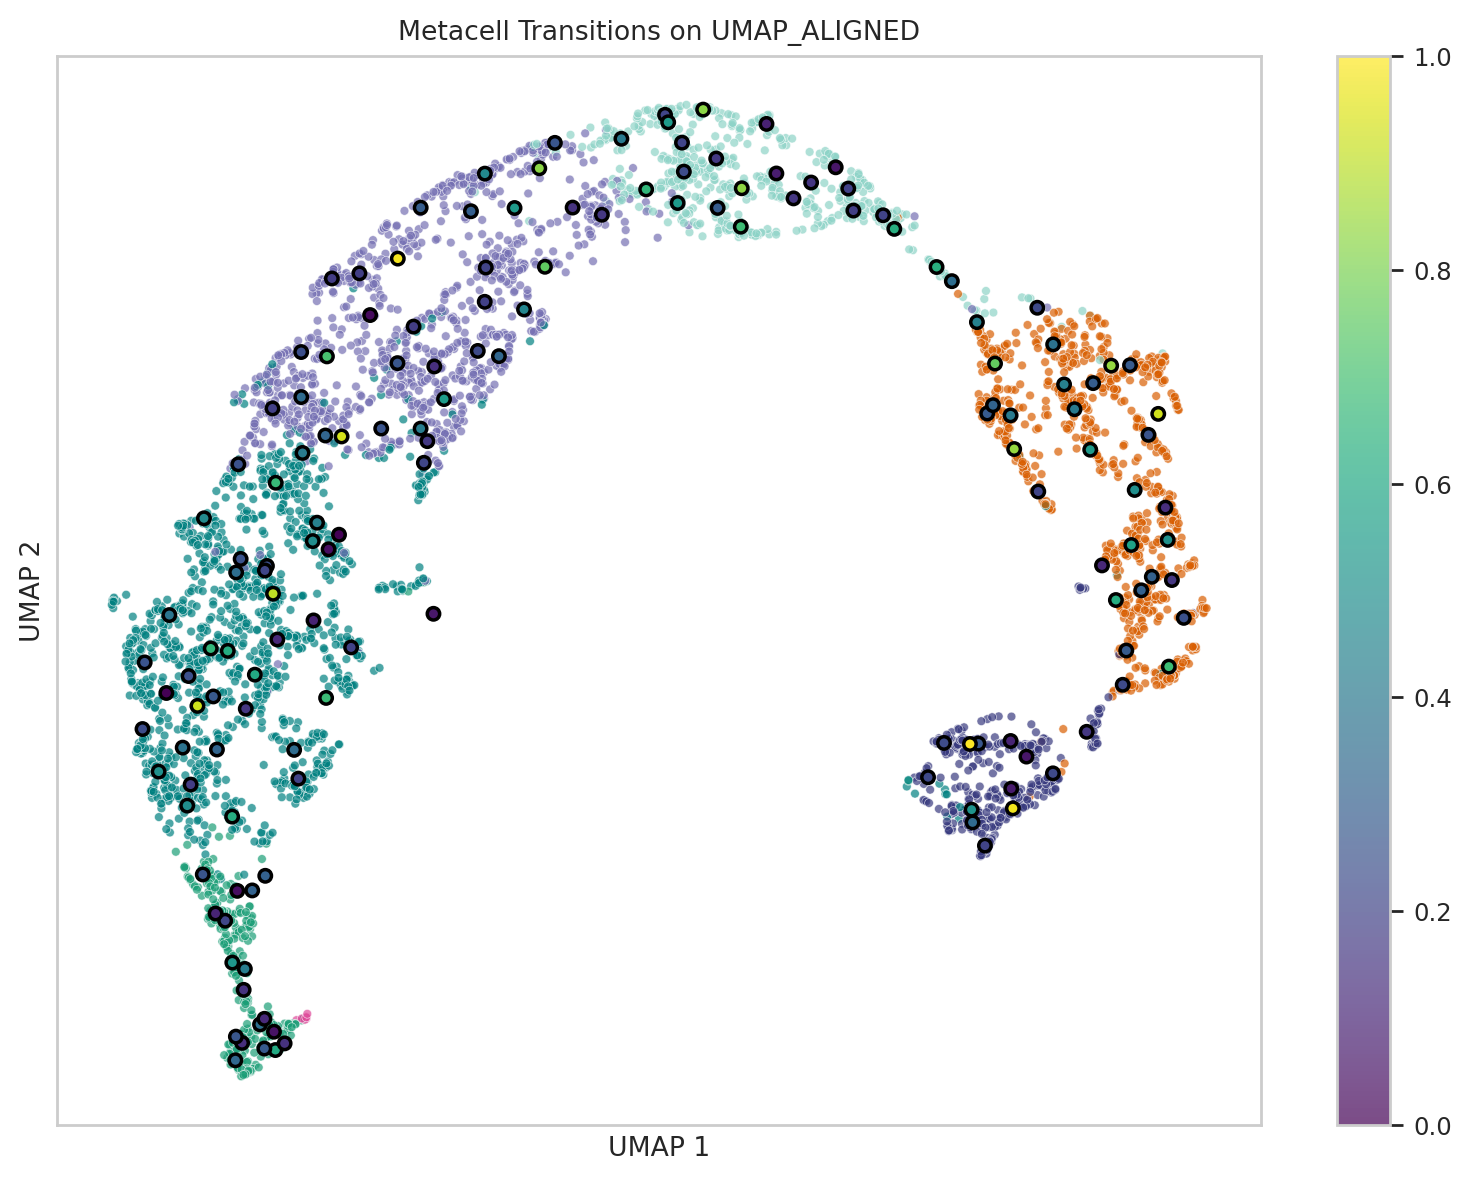

In [365]:
plot_metacell_cosine_sims(adata, X_metacell, cosine_sim_df, gene="tbx16", vmin=0, vmax=1)

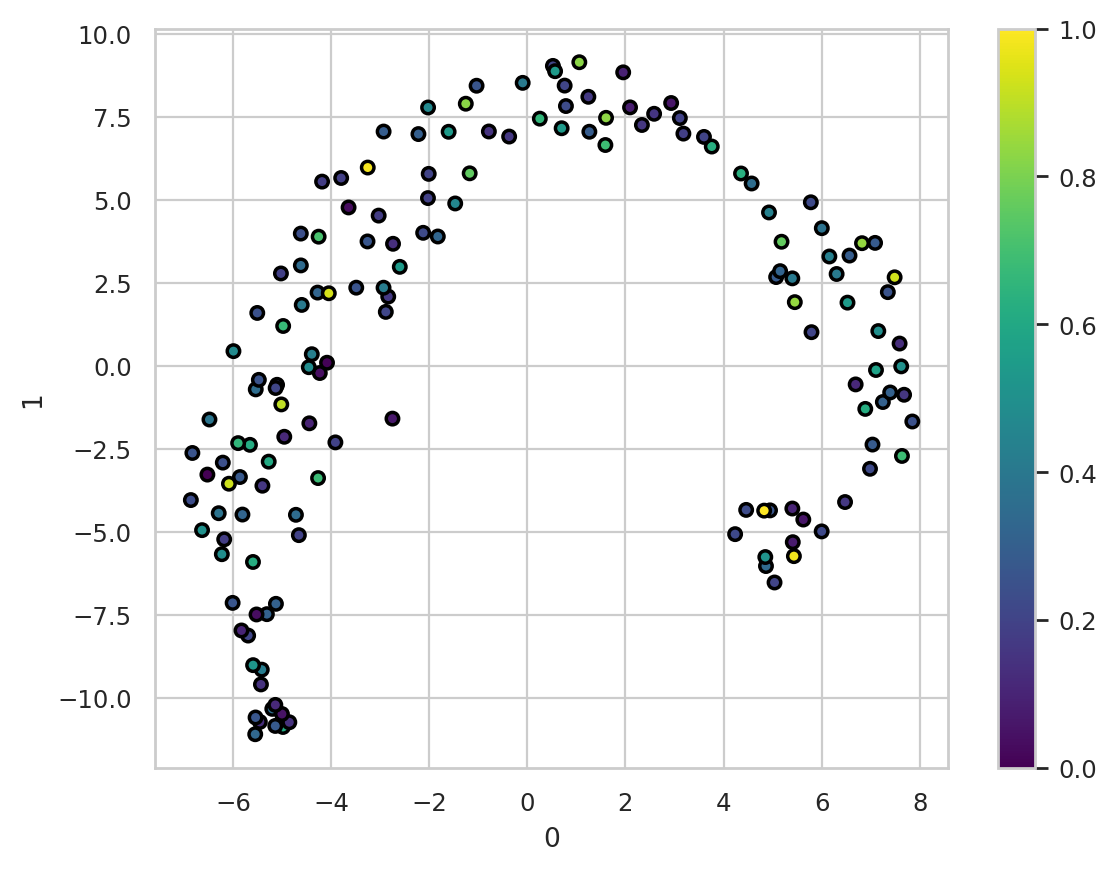

In [344]:
# Plot metacells
scatter = sns.scatterplot(
    x=0, y=1, s=20, hue='meox1', data=mcs_merged, edgecolor='black', linewidth=1.25,
    legend=None, palette="viridis", vmin=0, vmax=1)

# Add a colorbar
scatter.collections[0].set_cmap("viridis")
plt.colorbar(scatter.collections[0])
plt.show()

In [143]:
cosine_sim_df

arntl1b      arxb    atoh1a   barhl1a     barx2   bcl11aa  \
SEACell-35   0.588534  0.670341  0.587516  0.547354  0.584949  0.581425   
SEACell-93   0.734645  0.731579  0.728069  0.727458  0.729021  0.729482   
SEACell-151  0.462653  0.501094  0.466930  0.470235  0.467405  0.436312   
SEACell-13   0.555603  0.555152  0.556407  0.561546  0.556854  0.556092   
SEACell-130  0.410313  0.398547  0.459787  0.478723  0.461905  0.465883   
...               ...       ...       ...       ...       ...       ...   
SEACell-36   0.254369  0.252435  0.280012  0.285651  0.280078  0.282153   
SEACell-7    0.572380  0.547966  0.551588  0.564600  0.551693  0.559326   
SEACell-92   0.333149  0.383279  0.368792  0.350992  0.368921  0.362634   
SEACell-27   0.549285  0.552310  0.524341  0.520404  0.524174  0.522891   
SEACell-0    0.254218  0.306317  0.285746  0.269718  0.285746  0.278665   

              bcl11ab   bhlha15      cdx4     cebpb  ...       ved      vent  \
SEACell-35   0.587591  0.586217  0.785340  0.588778  ...  0.735312  0.812876   
SEACell-93   0.727582  0.727634  0.812144  0.724851  ...  0.738471  0.635644   
SEACell-151  0.463528  0.467503  0.302596  0.463800  ...  0.302757  0.378554   
SEACell-13   0.556263  0.555849  0.388980  0.558762  ...  0.471490  0.819069   
SEACell-130  0.459999  0.462426  0.274645  0.470847  ...  0.284622  0.236144   
...               ...       ...       ...       ...  ...       ...       ...   
SEACell-36   0.281057  0.280813  0.132436  0.282921  ...  0.159077  0.119887   
SEACell-7    0.552212  0.551693  0.268863  0.553985  ...  0.287441  0.440640   
SEACell-92   0.368106  0.368792  0.589808  0.369282  ...  0.664446  0.716978   
SEACell-27   0.522900  0.524332  0.387441  0.522004  ...  0.364864  0.336959   
SEACell-0    0.285561  0.285746  0.348526  0.286987  ...  0.291407  0.314625   

                  vox      wt1a    zbtb18     zeb1a      zic1     zic2a  \
SEACell-35   0.751295  0.587826  0.632764  0.600696  0.608710  0.738403   
SEACell-93   0.758938  0.728479  0.441874  0.730383  0.737158  0.694038   
SEACell-151  0.294713  0.468671  0.517969  0.493514  0.458411  0.434832   
SEACell-13   0.494822  0.557456  0.531105  0.578932  0.541519  0.511729   
SEACell-130  0.241611  0.472394  0.322121  0.456391  0.449920  0.338589   
...               ...       ...       ...       ...       ...       ...   
SEACell-36   0.195416  0.282872  0.241180  0.282797  0.274133  0.251489   
SEACell-7    0.275049  0.558390  0.452992  0.540601  0.544547  0.513627   
SEACell-92   0.696587  0.351248  0.387434  0.373236  0.382946  0.425999   
SEACell-27   0.367600  0.519284  0.546048  0.533856  0.530242  0.549928   
SEACell-0    0.288155  0.280103  0.271472  0.288627  0.296884  0.356545   

                zic2b      zic3  
SEACell-35   0.681177  0.609647  
SEACell-93   0.754416  0.381377  
SEACell-151  0.329534  0.496862  
SEACell-13   0.561098  0.569676  
SEACell-130  0.328733  0.285912  
...               ...       ...  
SEACell-36   0.162949  0.210228  
SEACell-7    0.448912  0.423288  
SEACell-92   0.492490  0.556972  
SEACell-27   0.577998  0.566794  
SEACell-0    0.420636  0.483941  

[153 rows x 241 columns]

In [144]:
cosine_sim_df["celltype"] = cosine_sim_df.index.map(most_prevalent)
cosine_sim_df.head()

arntl1b      arxb    atoh1a   barhl1a     barx2   bcl11aa  \
SEACell-35   0.588534  0.670341  0.587516  0.547354  0.584949  0.581425   
SEACell-93   0.734645  0.731579  0.728069  0.727458  0.729021  0.729482   
SEACell-151  0.462653  0.501094  0.466930  0.470235  0.467405  0.436312   
SEACell-13   0.555603  0.555152  0.556407  0.561546  0.556854  0.556092   
SEACell-130  0.410313  0.398547  0.459787  0.478723  0.461905  0.465883   

              bcl11ab   bhlha15      cdx4     cebpb  ...      vent       vox  \
SEACell-35   0.587591  0.586217  0.785340  0.588778  ...  0.812876  0.751295   
SEACell-93   0.727582  0.727634  0.812144  0.724851  ...  0.635644  0.758938   
SEACell-151  0.463528  0.467503  0.302596  0.463800  ...  0.378554  0.294713   
SEACell-13   0.556263  0.555849  0.388980  0.558762  ...  0.819069  0.494822   
SEACell-130  0.459999  0.462426  0.274645  0.470847  ...  0.236144  0.241611   

                 wt1a    zbtb18     zeb1a      zic1     zic2a     zic2b  \
SEACell-35   0.587826  0.632764  0.600696  0.608710  0.738403  0.681177   
SEACell-93   0.728479  0.441874  0.730383  0.737158  0.694038  0.754416   
SEACell-151  0.468671  0.517969  0.493514  0.458411  0.434832  0.329534   
SEACell-13   0.557456  0.531105  0.578932  0.541519  0.511729  0.561098   
SEACell-130  0.472394  0.322121  0.456391  0.449920  0.338589  0.328733   

                 zic3          celltype  
SEACell-35   0.609647       spinal_cord  
SEACell-93   0.381377               PSM  
SEACell-151  0.496862  neural_posterior  
SEACell-13   0.569676              NMPs  
SEACell-130  0.285912               PSM  

[5 rows x 242 columns]

In [146]:
cosine_sim_df_avg = cosine_sim_df.groupby("celltype").mean()
df_averaged = cosine_sim_df_avg.reset_index()

df_averaged

celltype   arntl1b      arxb    atoh1a   barhl1a     barx2  \
0              NMPs  0.525136  0.525600  0.522789  0.528824  0.522745   
1               PSM  0.539569  0.532835  0.541139  0.541145  0.541169   
2  neural_posterior  0.514914  0.514051  0.514861  0.515497  0.514950   
3           somites  0.425756  0.434323  0.431308  0.428045  0.431473   
4       spinal_cord  0.527798  0.529827  0.527976  0.520287  0.527591   
5          tail_bud  0.563675  0.563107  0.565112  0.564760  0.565067   

    bcl11aa   bcl11ab   bhlha15      cdx4  ...       ved      vent       vox  \
0  0.522151  0.522822  0.522753  0.424799  ...  0.446162  0.420827  0.450044   
1  0.541259  0.541097  0.541192  0.435236  ...  0.437707  0.469735  0.436137   
2  0.508886  0.515050  0.514623  0.377437  ...  0.385128  0.441841  0.382399   
3  0.429627  0.431295  0.431488  0.320213  ...  0.318354  0.399509  0.315367   
4  0.525098  0.528121  0.527707  0.471304  ...  0.464438  0.492618  0.462748   
5  0.565358  0.565096  0.565084  0.439699  ...  0.442666  0.422797  0.438481   

       wt1a    zbtb18     zeb1a      zic1     zic2a     zic2b      zic3  
0  0.522977  0.525142  0.522088  0.526763  0.503247  0.509488  0.529596  
1  0.541516  0.491892  0.541544  0.541086  0.536482  0.492541  0.447894  
2  0.514631  0.515262  0.517530  0.511176  0.464211  0.401388  0.505420  
3  0.428632  0.414247  0.431342  0.432708  0.439085  0.394711  0.421371  
4  0.528229  0.528992  0.528749  0.531595  0.539334  0.503772  0.529270  
5  0.564858  0.562758  0.565911  0.565107  0.562086  0.549138  0.534216  

[6 rows x 242 columns]

In [309]:
df_averaged.drop("celltype", axis=1).mean(axis=0)

arntl1b    0.516141
arxb       0.516624
atoh1a     0.517197
barhl1a    0.516426
barx2      0.517166
             ...   
zeb1a      0.517861
zic1       0.518073
zic2a      0.507407
zic2b      0.475173
zic3       0.494628
Length: 241, dtype: float64

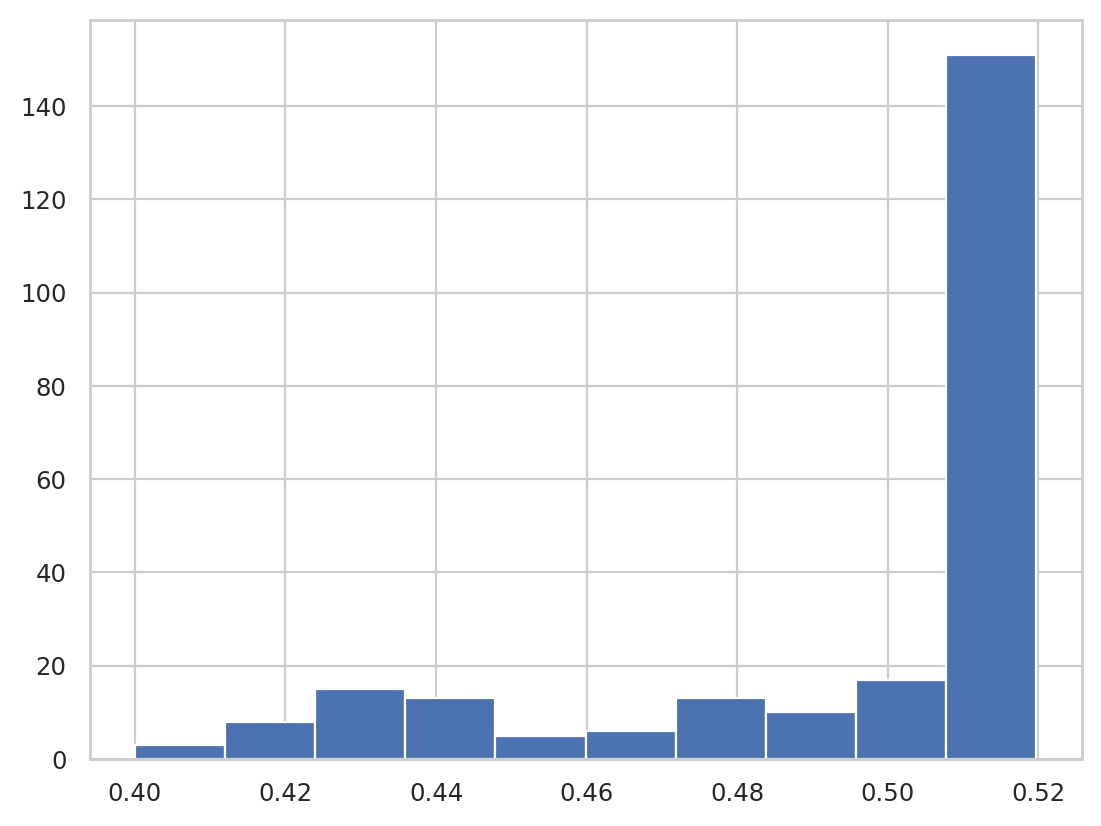

In [311]:
plt.hist(df_averaged.drop("celltype", axis=1).mean(axis=0))
plt.show()

In [315]:
df_avg_per_gene = df_averaged.drop("celltype", axis=1).mean(axis=0)
df_avg_per_gene

arntl1b    0.516141
arxb       0.516624
atoh1a     0.517197
barhl1a    0.516426
barx2      0.517166
             ...   
zeb1a      0.517861
zic1       0.518073
zic2a      0.507407
zic2b      0.475173
zic3       0.494628
Length: 241, dtype: float64

In [316]:
df_avg_per_gene[df_avg_per_gene<0.45]

cdx4       0.411448
ctcf       0.435757
dlx3b      0.399975
etv5a      0.446968
etv5b      0.417758
eve1       0.434115
foxc1a     0.432343
foxd5      0.431435
hmga1a     0.406731
hoxa9a     0.429971
hoxa9b     0.446905
hoxb10a    0.438303
hoxb7a     0.434359
hoxb9a     0.434059
hoxd4a     0.445991
hoxd9a     0.424192
irx1b      0.438053
irx7       0.415885
lbx2       0.424193
lin28a     0.424371
meis1a     0.449167
meis2a     0.438083
meis3      0.445757
meox1      0.423111
msx1b      0.447441
myf5       0.447743
rarga      0.433478
rx3        0.427225
six3b      0.430797
sox11a     0.412490
sox11b     0.433129
sox19a     0.416088
sox19b     0.446630
sox2       0.445852
tbx16      0.435139
tcf3b      0.446561
tgif1      0.416287
ved        0.415743
vent       0.441221
vox        0.414196
dtype: float64

In [300]:
trans_probs_WT = oracle.adata.obsp["T_fwd_WT_global_nmps"]
trans_probs1 = oracle.adata.obsp["T_fwd_meox1_KO"]
trans_probs2 = oracle.adata.obsp["T_fwd_pax6b_KO"]

In [178]:
df_averaged.drop("celltype", axis=1).values.flatten()

array([0.52513573, 0.5255999 , 0.52278887, ..., 0.56208558, 0.54913818,
       0.5342159 ])

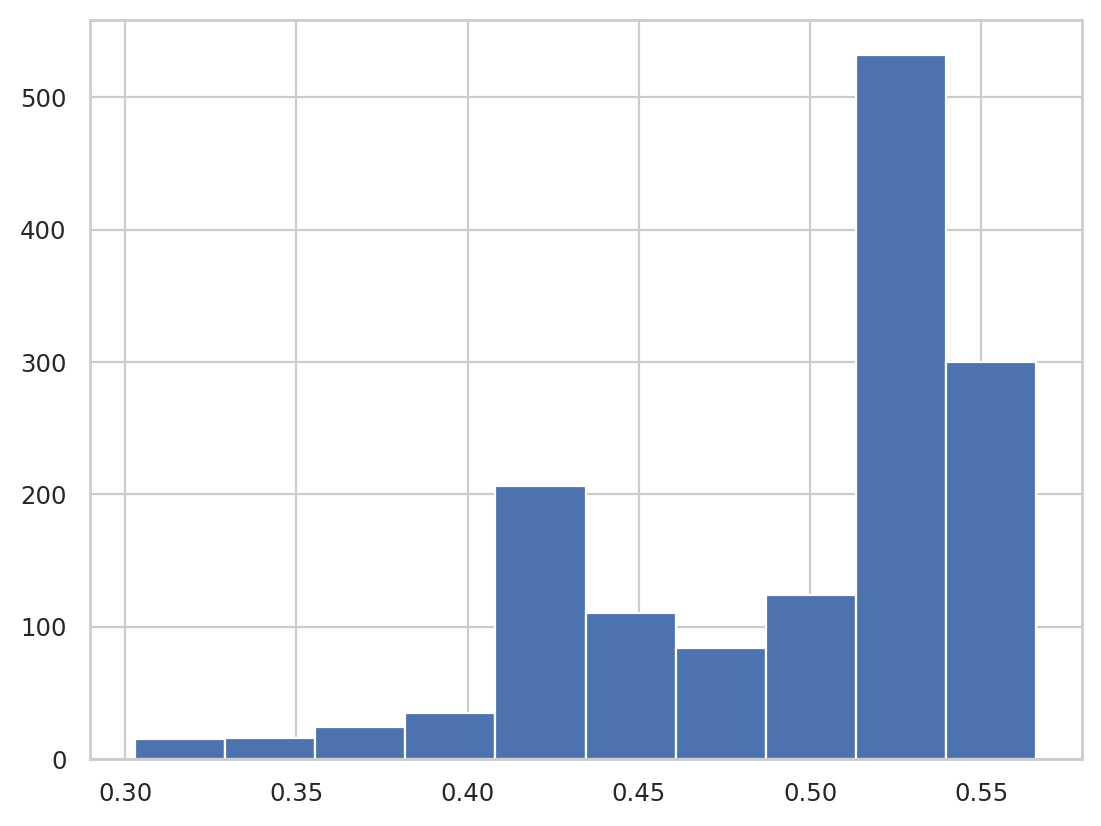

In [179]:
plt.hist(df_averaged.drop("celltype", axis=1).values.flatten())
plt.show()

In [188]:
df_averaged.loc[:,"meis3"]

0    0.459995
1    0.492827
2    0.437402
3    0.306094
4    0.467345
5    0.510880
Name: meis3, dtype: float64

In [184]:
df_averaged_per_gene = df_averaged.mean(axis=0)
df_averaged_per_gene

arntl1b    0.516141
arxb       0.516624
atoh1a     0.517197
barhl1a    0.516426
barx2      0.517166
             ...   
zeb1a      0.517861
zic1       0.518073
zic2a      0.507407
zic2b      0.475173
zic3       0.494628
Length: 241, dtype: float64

In [185]:
df_averaged_per_gene[df_averaged_per_gene<0.4]

dlx3b    0.399975
dtype: float64

In [ ]:
# # Color palette for cell types
# cell_type_color_dict = {
#     'NMPs': '#8dd3c7',
#     'PSM': '#008080',
#     'fast_muscle': '#df4b9b',
#     'neural_posterior': '#393b7f',
#     'somites': '#1b9e77',
#     'spinal_cord': '#d95f02',
#     'tail_bud': '#7570b3'
# }

# # computing the average of 2D transition vectors @Metacell level
# def average_2D_trans_vecs_metacells(adata, metacell_col="SEACell", 
#                                     basis='umap_aligned',key_added='WT'):
#     X_umap = adata.obsm[f'X_{basis}']
#     V_cell = adata.obsm[f'{key_added}_{basis}']  # Your cell-level 2D transition vectors
#     # metacells = adata.obs[metacell_col].cat.codes
    
#     # Convert metacell column to categorical if it's not already
#     if not pd.api.types.is_categorical_dtype(adata.obs[metacell_col]):
#         metacells = pd.Categorical(adata.obs[metacell_col])
#     else:
#         metacells = adata.obs[metacell_col]
#     # number of metacells    
#     n_metacells = len(metacells.categories)
    
#     # X_metacell is the average UMAP position of the metacells
#     # V_metacell is the average transition vector of the metacells
#     X_metacell = np.zeros((n_metacells, 2))
#     V_metacell = np.zeros((n_metacells, 2))
    
#     for i, category in enumerate(metacells.categories):
#         mask = metacells == category
#         X_metacell[i] = X_umap[mask].mean(axis=0)
#         V_metacell[i] = V_cell[mask].mean(axis=0)
    
#     return X_metacell, V_metacell

# # plotting function for the averaged trans_vectors
# # metacell_col = 'SEACell'  # Replace with your metacell column name
# # basis="umap_aligned"
# def plot_metacell_transitions(adata, X_metacell, V_metacell,data_id,
#                                 figpath=None,
#                                 metacell_col="SEACell", 
#                                 annotation_class="manual_annotation",
#                                 basis='umap_aligned', genotype="WT",
#                                 cell_type_color_dict = cell_type_color_dict,
#                                 cell_size=10, SEACell_size=20,
#                                 scale=1, arrow_scale=15, arrow_width=0.002, dpi=120):
    
#     # create a figure object (matplotlib)
#     fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

#     # Prepare data for plotting
#     umap_coords = pd.DataFrame(adata.obsm[f'X_{basis}'], columns=[0, 1], index=adata.obs_names)
#     umap_data = umap_coords.join(adata.obs[[metacell_col, annotation_class]])
#     umap_data = umap_data.rename(columns={annotation_class: 'celltype'})

#     # Plot single cells
#     sns.scatterplot(
#         x=0, y=1, hue='celltype', data=umap_data, s=cell_size, 
#         palette=cell_type_color_dict, legend=None, ax=ax, alpha=0.7
#     )

#     # Calculate most prevalent cell type for each metacell
#     most_prevalent = adata.obs.groupby(metacell_col)[annotation_class].agg(lambda x: x.value_counts().idxmax())

#     # Prepare metacell data
#     mcs = umap_data.groupby(metacell_col).mean().reset_index()
#     mcs['celltype'] = most_prevalent.values

#     # Plot metacells
#     sns.scatterplot(
#         x=0, y=1, s=SEACell_size, hue='celltype', data=mcs,
#         palette=cell_type_color_dict, edgecolor='black', linewidth=1.25,
#         legend=None, ax=ax
#     )

#     # Plot transition vectors
#     Q = ax.quiver(X_metacell[:, 0], X_metacell[:, 1], V_metacell[:, 0], V_metacell[:, 1],
#                 angles='xy', scale_units='xy', scale=1/arrow_scale, width=arrow_width,
#                 color='black', alpha=0.8)

#     # Customize the plot
#     ax.set_xlabel('UMAP 1')
#     ax.set_ylabel('UMAP 2')
#     # Remove x and y ticks
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.grid(False)

#     # # Create custom legend
#     # handles = [mpatches.Patch(color=color, label=label) 
#     #         for label, color in cell_type_color_dict.items() 
#     #         if label in umap_data['celltype'].unique()]
#     # ax.legend(handles=handles, title='Cell Types', bbox_to_anchor=(1.05, 1), loc='upper left')

#     plt.title(f'Metacell Transitions on {basis.upper()}')
#     plt.tight_layout()
#     plt.grid(False)
#     plt.savefig(figpath + f"umap_{genotype}_metacell_aggre_trans_probs_{data_id}.png")
#     plt.savefig(figpath + f"umap_{genotype}_metacell_aggre_trans_probs_{data_id}.pdf")
#     # plt.show()
#     # plt.show()
#     return fig

## Step 4. computng the cosine.similarity (per cell) between WT and KO

- inspired by what we did for Sarah's RNA velocity paper

In [370]:
from tqdm import tqdm

list_datasets = ['TDR126','TDR127','TDR128','TDR118',
                 'TDR119','TDR125','TDR124']

dict_cos_sims = {}

oracle_path = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/09_NMPs_subsetted_v2/"

for data_id in tqdm(list_datasets, desc="Processing Datasets"):
    print(data_id)
    
    # load the oracle object
    oracle = co.load_hdf5(oracle_path + f"15_{data_id}_in_silico_KO_trans_probs_added.celloracle.oracle")
    
    # load the metacell info
    metacell = pd.read_csv(oracle_path + f"metacells/{data_id}_seacells_obs_manual_annotation_30cells.csv", index_col=0)
    
    # add the metacell information to the oracle.adata
    metacell_dict = metacell.SEACell.to_dict()
    oracle.adata.obs["SEACell"] = oracle.adata.obs_names.map(metacell_dict)
    oracle.adata.obs.head()
    
    # Calculate most prevalent cell type for each metacell
    most_prevalent = oracle.adata.obs.groupby("SEACell")["manual_annotation"].agg(lambda x: x.value_counts().idxmax())
    most_prevalent

    # average the 2D embedding and 2D transition vectors across "metacells"
    trans_probs_metacell_WT = compute_metacell_transitions(oracle.adata, 
                                                        trans_key="T_fwd_WT_global_nmps", 
                                                        metacell_key="SEACell")

    # Initialize an empty DataFrame with celltypes as the index
    metacells = trans_probs_metacell_WT.index
    cosine_sim_df = pd.DataFrame(index=metacells)
    
    # Compute cosine similarities for each gene knockout
    for gene in tqdm(oracle.active_regulatory_genes, desc=f"Processing Genes for {data_id}"):
        # Compute transition probabilities for the current gene knockout
        trans_key = f"T_fwd_{gene}_KO"
        trans_probs_metacell_KO = compute_metacell_transitions(oracle.adata, trans_key=trans_key, 
                                                                metacell_key="SEACell")
        
        # Compute cosine similarities
        cosine_similarities = compute_row_cosine_similarities(trans_probs_metacell_WT, trans_probs_metacell_KO)
        
        # Add the cosine similarities as a new column to the DataFrame
        cosine_sim_df[gene] = cosine_similarities

    # Display the resulting DataFrame (metacell-by-genes)
    cosine_sim_df["celltype"] = cosine_sim_df.index.map(most_prevalent)

    # average the cosine similarities across cell types
    cosine_sim_df_avg = cosine_sim_df.groupby("celltype").mean()
    df_averaged = cosine_sim_df_avg.reset_index()
    
    # save this into the master dictionary (dict)
    dict_cos_sims[data_id] = df_averaged
    # save the raw version (metacells-by-genes)
    dict_cos_sims[f"{data_id}_metacells"] = cosine_sim_df
    
    print(f"{data_id} is completed")

Processing Datasets:   0%|          | 0/7 [00:00<?, ?it/s]

TDR126



Processing Datasets:   0%|          | 0/7 [19:10<?, ?it/s]


KeyboardInterrupt: 